# Damage Size Regression on Synthetic Data
In this notebook, we conduct experiments for damage size regression. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/synthetic_regression_AB.ipynb)

In [1]:
%load_ext rich

random_state = 42

## Prerequisites

In [2]:
import sys
import os
from pathlib import Path
import pandas as pd
from rich import print

# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    % pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    % pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
# Intel(R) Extension for Scikit-learn for speed-up
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import time
import glob
import sklearn
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

#...and download raw data if not already downloaded
from data_utils import init_data
# init_data(syn_data_path=SYN_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import (
    get_synth_regression_scoring,
    SHM_Scoring)
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)
from bench_utils import (
    classification_benchmark,
    repeat_experiment,
    extract_metrics)
from data_utils import (load_processed_data,
                        load_syn_reg_data,
                        FEATURE_LIST)
from shm_experiments import conduct_ab_reg_experiment

In [5]:
result_file = "synthetic_regression_AB_dssize_correlate.pkl"
result_file = Path(RESULT_PATH, result_file)

## Data Loading

In [6]:
X, y_ = load_syn_reg_data(
    data_path=SYN_DATA_PATH, target_col=FEATURE_LIST, min_radius=1.9, cache=True
)
y = y_[..., 1]

feat_data = pd.DataFrame(columns=FEATURE_LIST, data=y_)
feat_data

y_cat y_radius  y_sdv_fl y_sdv_core y_dens_core y_young_fl    y_dc  \
0         P      0.0  0.000125   0.019125       1.005     1.0043  1.0443   
1         P      0.0  0.000125   0.019125       1.005     1.0043  1.0443   
2         P      0.0  0.000125   0.019125       1.005     1.0043  1.0443   
3         P      0.0  0.000125   0.019125       1.005     1.0043  1.0443   
4         P      0.0  0.000125   0.019125       1.005     1.0043  1.0443   
...     ...      ...       ...        ...         ...        ...     ...   
28297     D     40.0  0.049875   0.017875      1.0271     0.9987  1.0158   
28298     D     40.0  0.049875   0.017875      1.0271     0.9987  1.0158   
28299     D     40.0  0.049875   0.017875      1.0271     0.9987  1.0158   
28300     D     40.0  0.049875   0.017875      1.0271     0.9987  1.0158   
28301     D     40.0  0.049875   0.017875      1.0271     0.9987  1.0158   

        y_pcf y_ec_pwas y_loss_f  
0      1.0047    1.0338   0.0162  
1      1.0047    1.0338   0.0169  
2      1.0047    1.0338   0.0188  
3      1.0047    1.0338   0.0227  
4      1.0047    1.0338     0.02  
...       ...       ...      ...  
28297  1.0217    1.0308   0.0188  
28298  1.0217    1.0308   0.0193  
28299  1.0217    1.0308   0.0197  
28300  1.0217    1.0308   0.0216  
28301  1.0217    1.0308   0.0226  

[28302 rows x 10 columns]

In [7]:
X.shape

(28302, 31)

In [8]:
cnt = Counter(y)
cnt


Counter({
    0.0: 990,
    2.2: 979,
    2.5: 979,
    2.8: 978,
    3.1: 986,
    3.4: 972,
    3.8: 973,
    4.1: 976,
    4.4: 979,
    4.7: 976,
    5.0: 977,
    6.7: 981,
    8.3: 972,
    10.0: 973,
    12.0: 969,
    14.0: 978,
    16.0: 980,
    18.0: 976,
    20.0: 974,
    22.0: 975,
    24.0: 980,
    26.0: 973,
    28.0: 983,
    30.0: 977,
    32.0: 967,
    34.0: 971,
    36.0: 976,
    38.0: 964,
    40.0: 968
})

## A-B Experiments

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.cluster import KMeans

from imblearn.under_sampling import ClusterCentroids
from imblearn.base import FunctionSampler
from imblearn.pipeline import Pipeline

In [10]:
def filter_pandas_ds(X, y, filter_tag, min_value, max_value):
    filter_idx = (X[filter_tag] >= min_value) & (X[filter_tag] <= max_value)

    X_filtered = np.stack(X["X"].to_numpy(), 0)[filter_idx]
    y_filtered = y[filter_idx]

    return X_filtered, y_filtered


def resampling_filter(X, y=None, filter_tag="y_radius", min_value=0.0, max_value=40.0, **_):
    X_, y_ = filter_pandas_ds(X, y, filter_tag, min_value, max_value)
    return X_, y_


def formater(X, y=None):
    if isinstance(X, pd.DataFrame):
        return np.stack(X["X"].to_numpy(), 0)

    return X


def resampling(X, y=None, sampler=lambda *_: _, **_):
    enc = OrdinalEncoder(dtype=np.int32)
    
    y_cls = enc.fit_transform(y.reshape(-1, 1))
    x_re, y_recls = sampler.fit_resample(X, y_cls)
    y_re = enc.inverse_transform(y_recls.reshape(-1, 1))

    return x_re, y_re.ravel()


def build_pipeline(samples_per_class, n_classes, random_state=None):
    strgy = dict(zip(range(n_classes), [samples_per_class] * n_classes))
    cc = ClusterCentroids(estimator=KMeans(n_init="auto"), sampling_strategy=strgy, random_state=random_state)
    
    
    estimator = KNeighborsRegressor(n_neighbors=1)
    pipeline = Pipeline([("format", FunctionTransformer(func=formater)),
                         ('sampler', FunctionSampler(func=resampling, kw_args=dict(sampler=cc), validate=False)), 
                         ('est', estimator)], 
                        verbose=False)

    return pipeline


def build_filter_pipeline(filter_tag, min_value, max_value, random_state=None):
    estimator = KNeighborsRegressor(n_neighbors=1)
    pipeline = Pipeline(
        [
            (
                "sampler",
                FunctionSampler(
                    func=resampling_filter,
                    kw_args=dict(
                        filter_tag=filter_tag, min_value=min_value, max_value=max_value
                    ),
                    validate=False,
                ),
            ),
            ("format", FunctionTransformer(func=formater)),
            ("est", estimator),
        ],
        verbose=False,
    )

    return pipeline

## Plot some results for overview

In [11]:
def test_feature(feature, n_subgroups=5, samples_per_class=10):
    models = []
    labels = {}

    value_min = feat_data[feature].min()
    value_max = feat_data[feature].max()
    gap = (value_max - value_min) / n_subgroups

    n_train_samples = int(X.shape[0] * 0.9)
    pipeline = build_filter_pipeline(filter_tag=feature, min_value=value_min, max_value=value_max, random_state=None)
    models.append([("A", pipeline)])
    labels["A"] = f"All data ({n_train_samples})"

    n_classes = len(np.unique(y))
    pipeline = build_pipeline(samples_per_class=samples_per_class, n_classes=n_classes, random_state=random_state)
    models.append([("B", pipeline)])
    labels["B"] = f"CCSampling({samples_per_class * n_classes})"

    for i, s in enumerate(np.linspace(value_min, value_max-gap, n_subgroups)):
        n_train_samples = ((feat_data[feature] >= s) & (feat_data[feature] <= s+gap)).to_numpy().sum()

        pipeline = build_filter_pipeline(filter_tag=feature, min_value=s, max_value=s+gap, random_state=None)
        models.append([(f"C{i}", pipeline)])
        labels[f"C{i}"] = f"{s:.2e} <= {feature} <= {s+gap:.2e} ({n_train_samples})"

    scoring = get_synth_regression_scoring()
    X_ext = feat_data.copy()
    X_ext["X"] = list(X)

    results = conduct_ab_reg_experiment(X=X_ext, y=y,
                                        estimators=models,
                                        n_splits=32,
                                        test_size=0.1,
                                        scoring=scoring,
                                        random_state=random_state)

    plot_metrics(extract_metrics(results, ['test_mse_0.0_40.0',
                                           'test_mse_2.8_40.0',
                                           'test_mse_5.0_40.0']))
    plt.tight_layout()
    plt.show()

    shm_scoring = SHM_Scoring()
    plot_metrics(extract_metrics(results, shm_scoring.SYNTH_MSE_RESULTS))
    plt.gca().get_legend().remove()
    plt.show()
    
    plot_metrics(extract_metrics(results, shm_scoring.SYNTH_REL_ERROR))
    plt.gca().get_legend().remove()
    plt.show()

    print(labels)

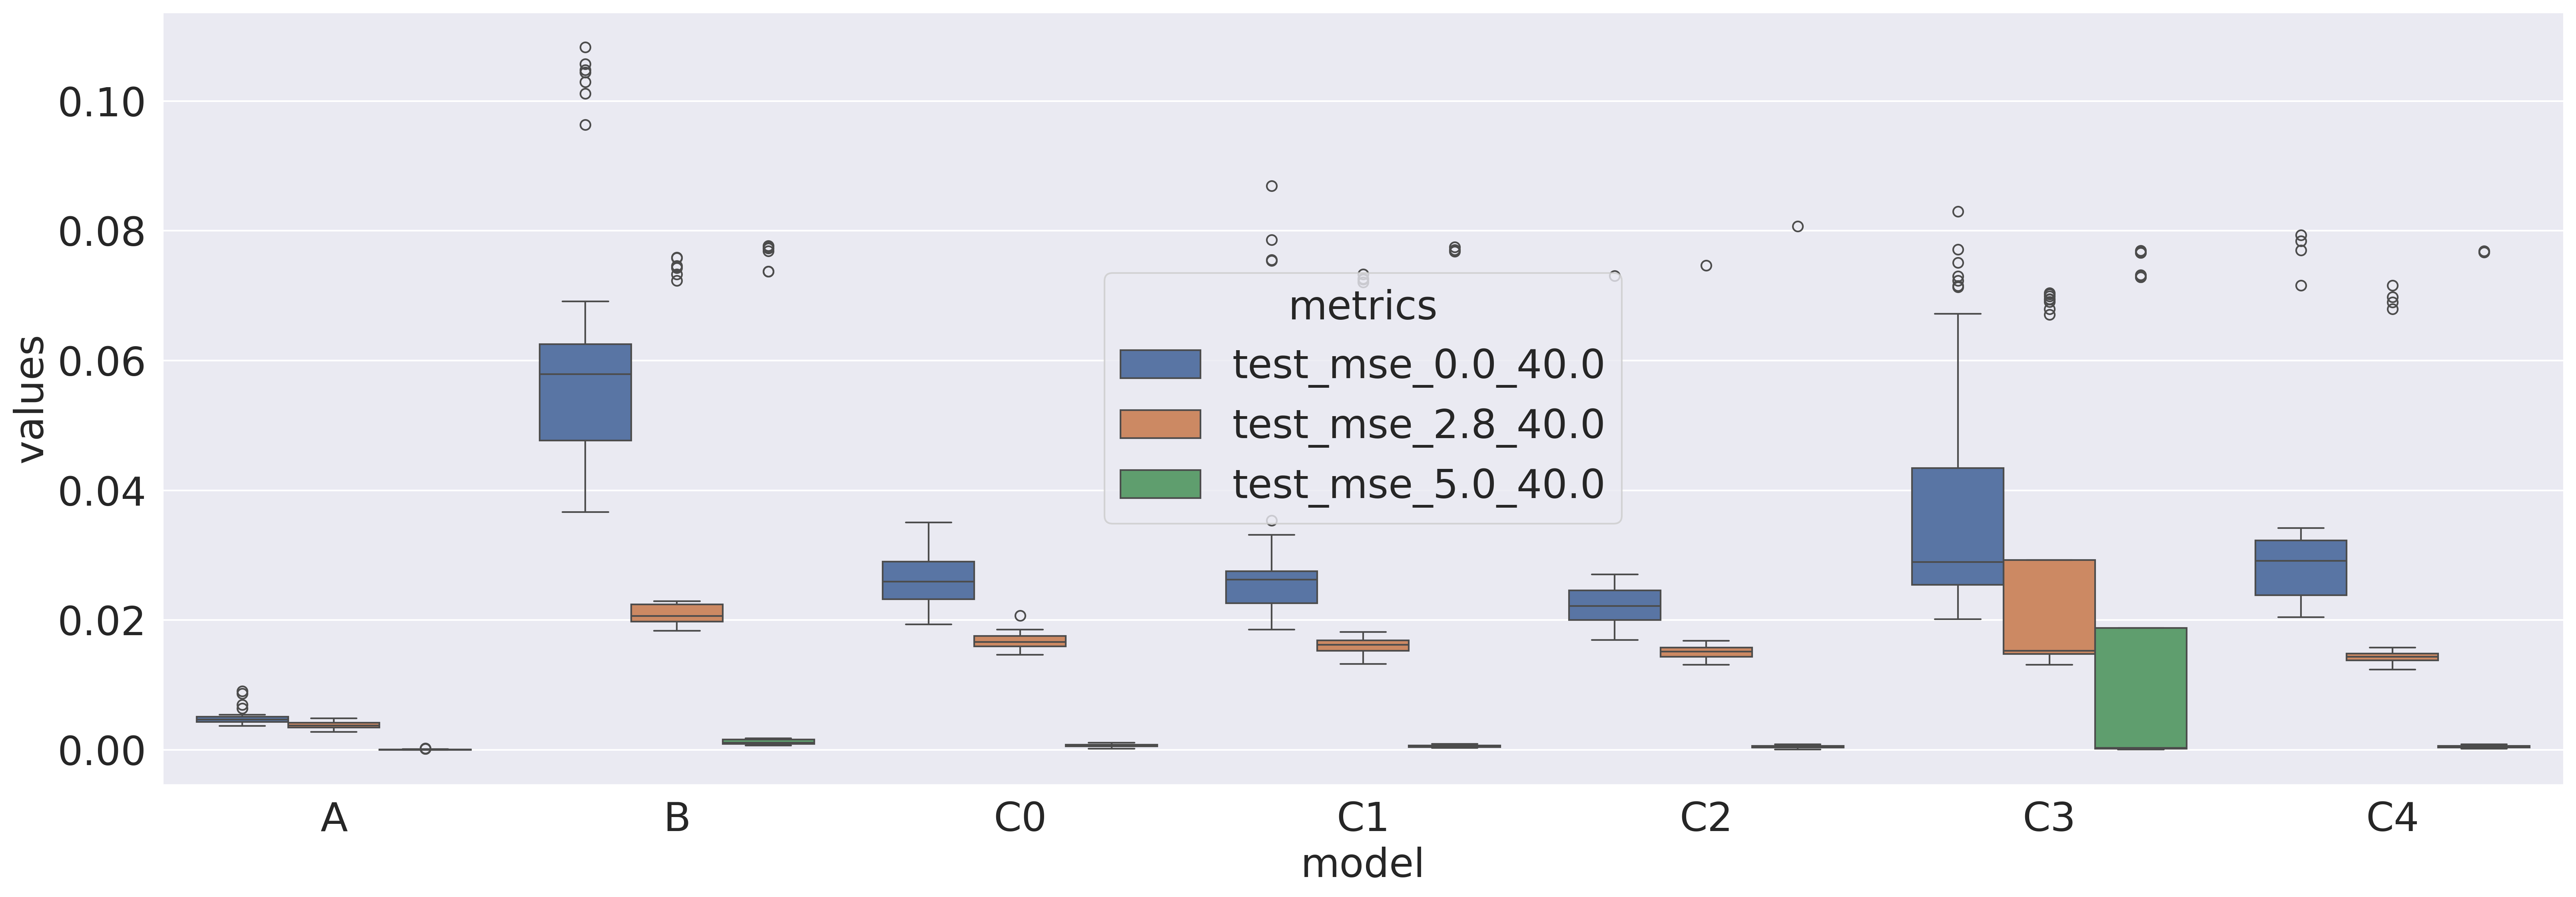

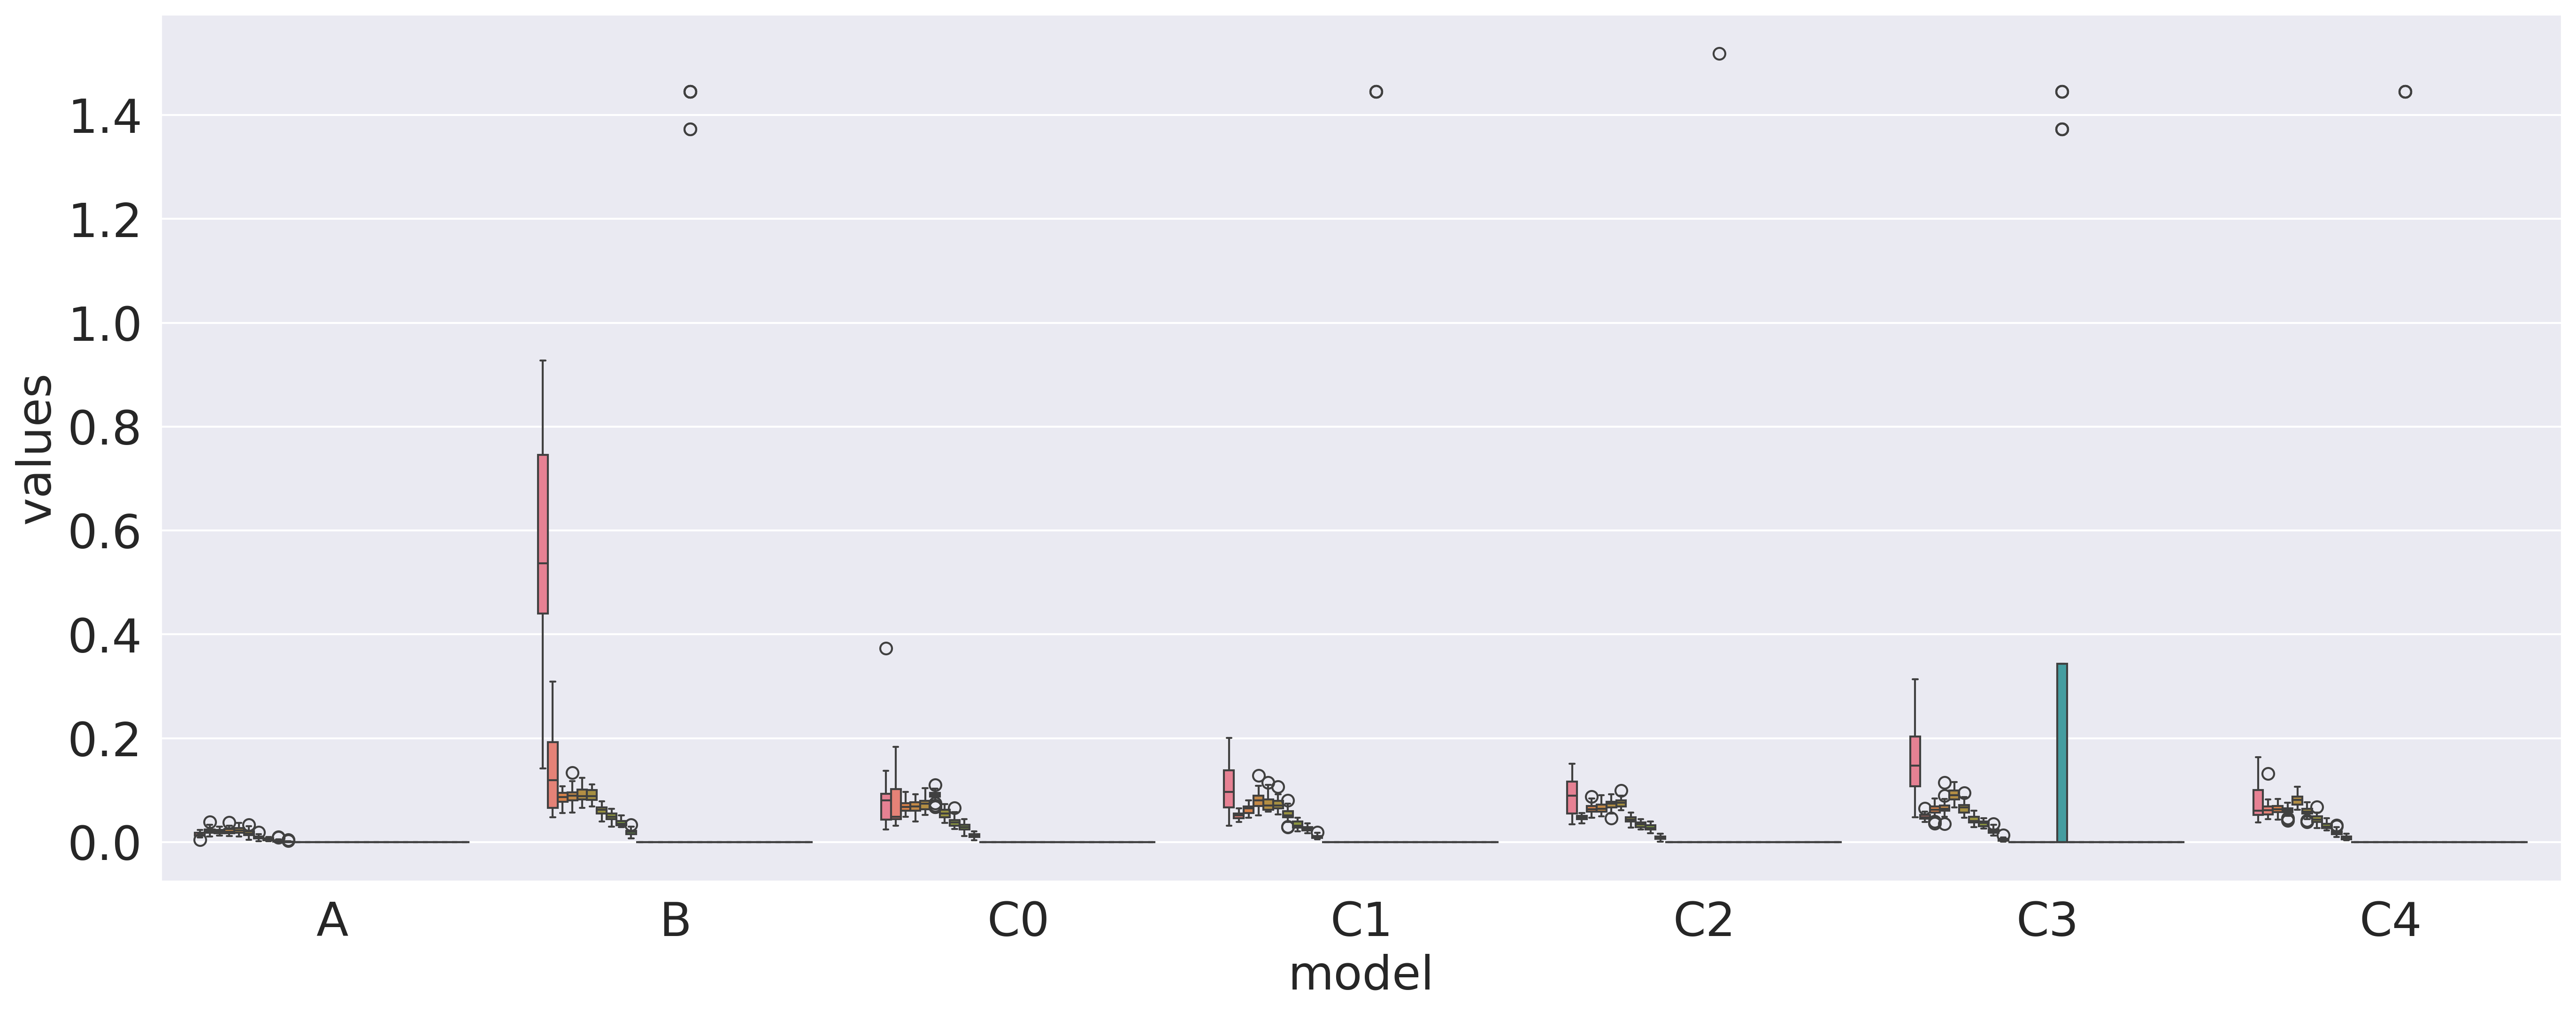

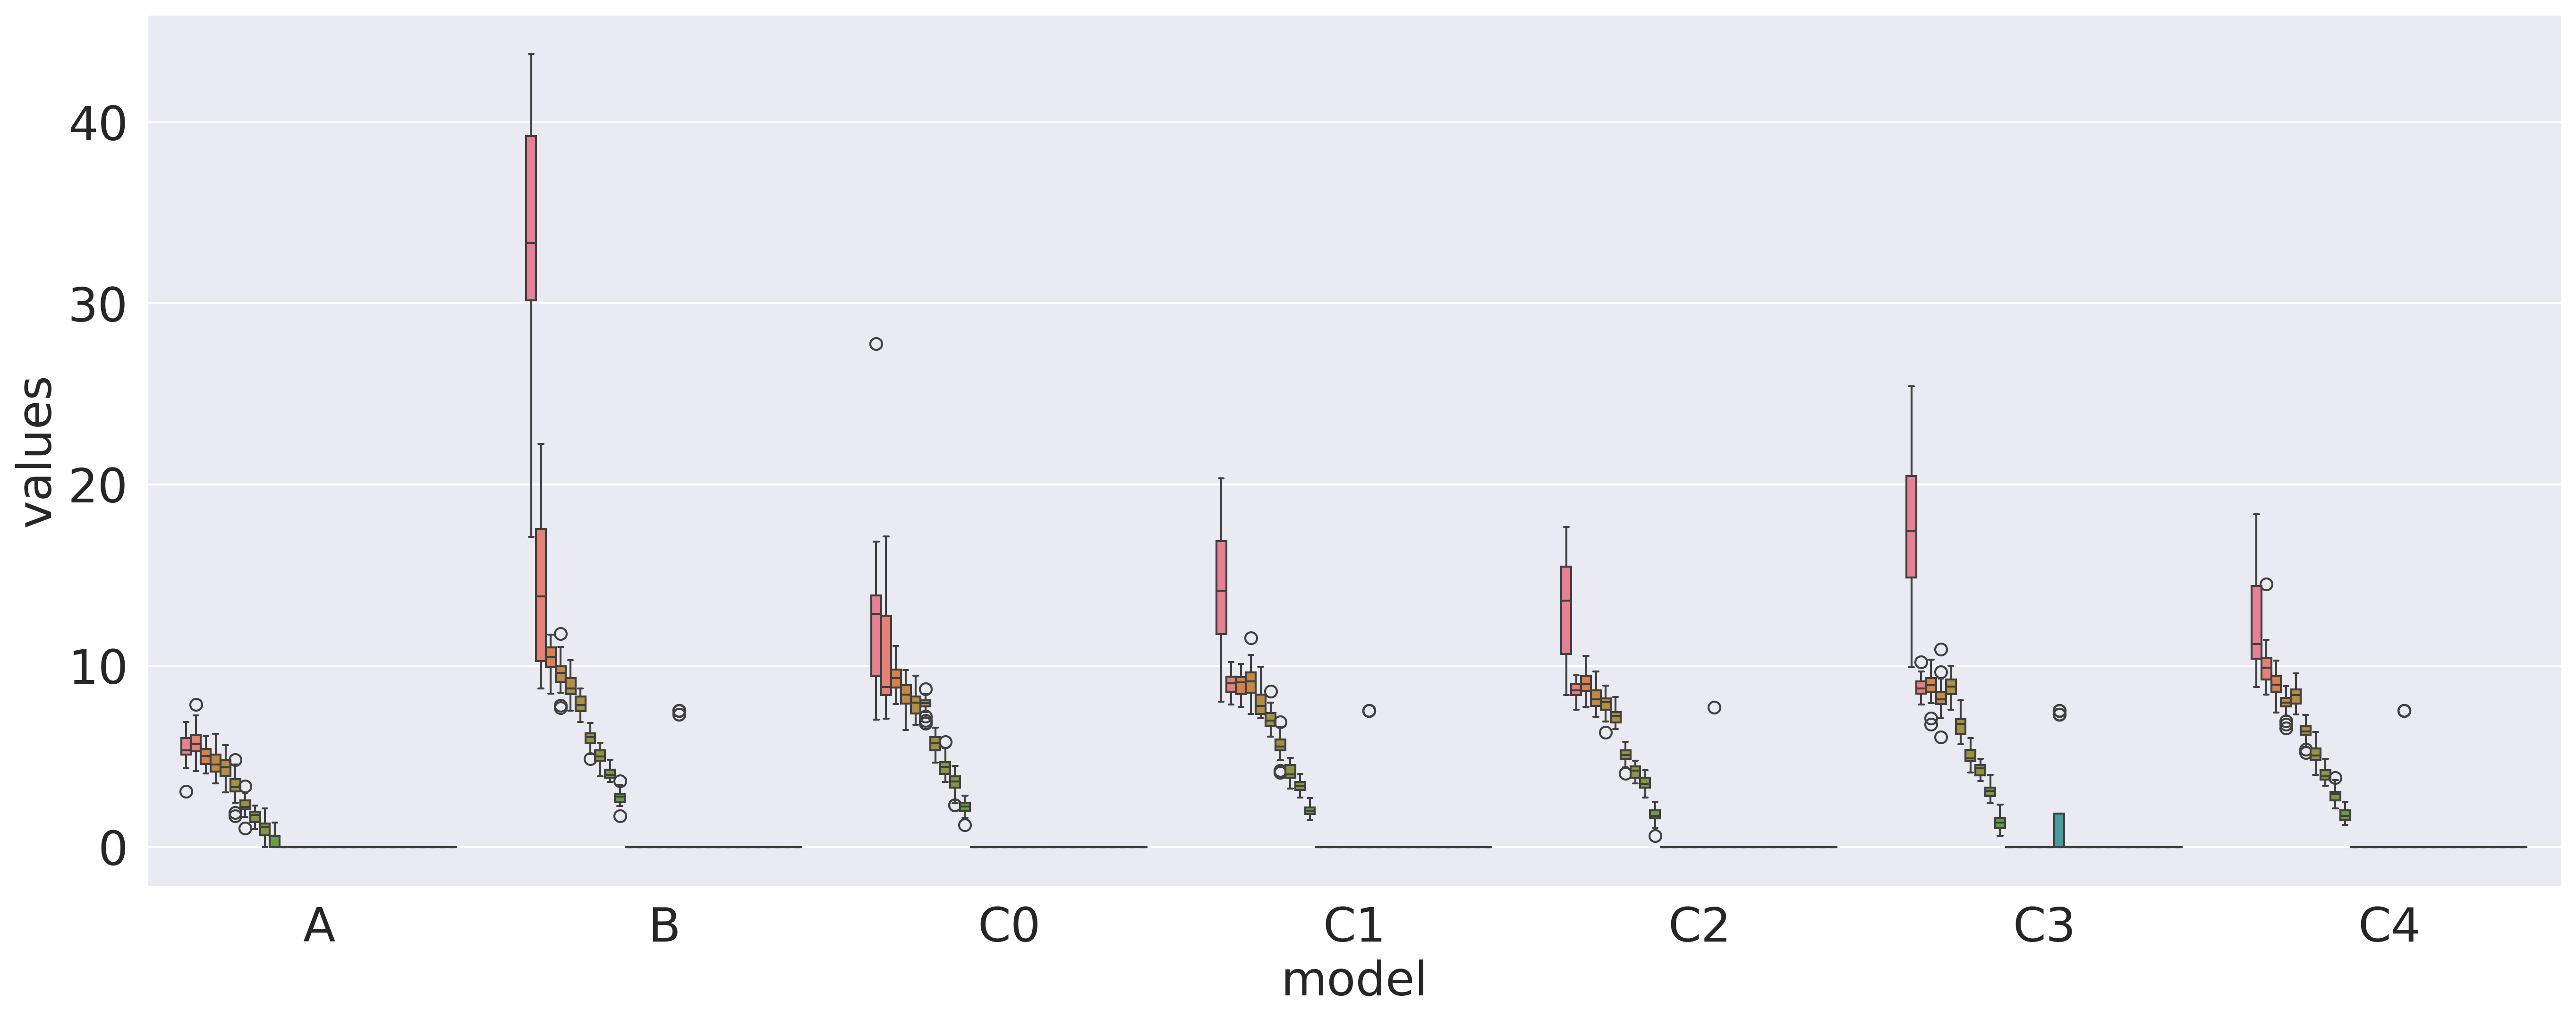

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '1.25e-04 <= y_sdv_fl <= 1.01e-02 (5676)',
    'C1': '1.01e-02 <= y_sdv_fl <= 2.00e-02 (5646)',
    'C2': '2.00e-02 <= y_sdv_fl <= 3.00e-02 (5659)',
    'C3': '3.00e-02 <= y_sdv_fl <= 3.99e-02 (5646)',
    'C4': '3.99e-02 <= y_sdv_fl <= 4.99e-02 (5675)'
}

In [12]:
test_feature("y_sdv_fl")

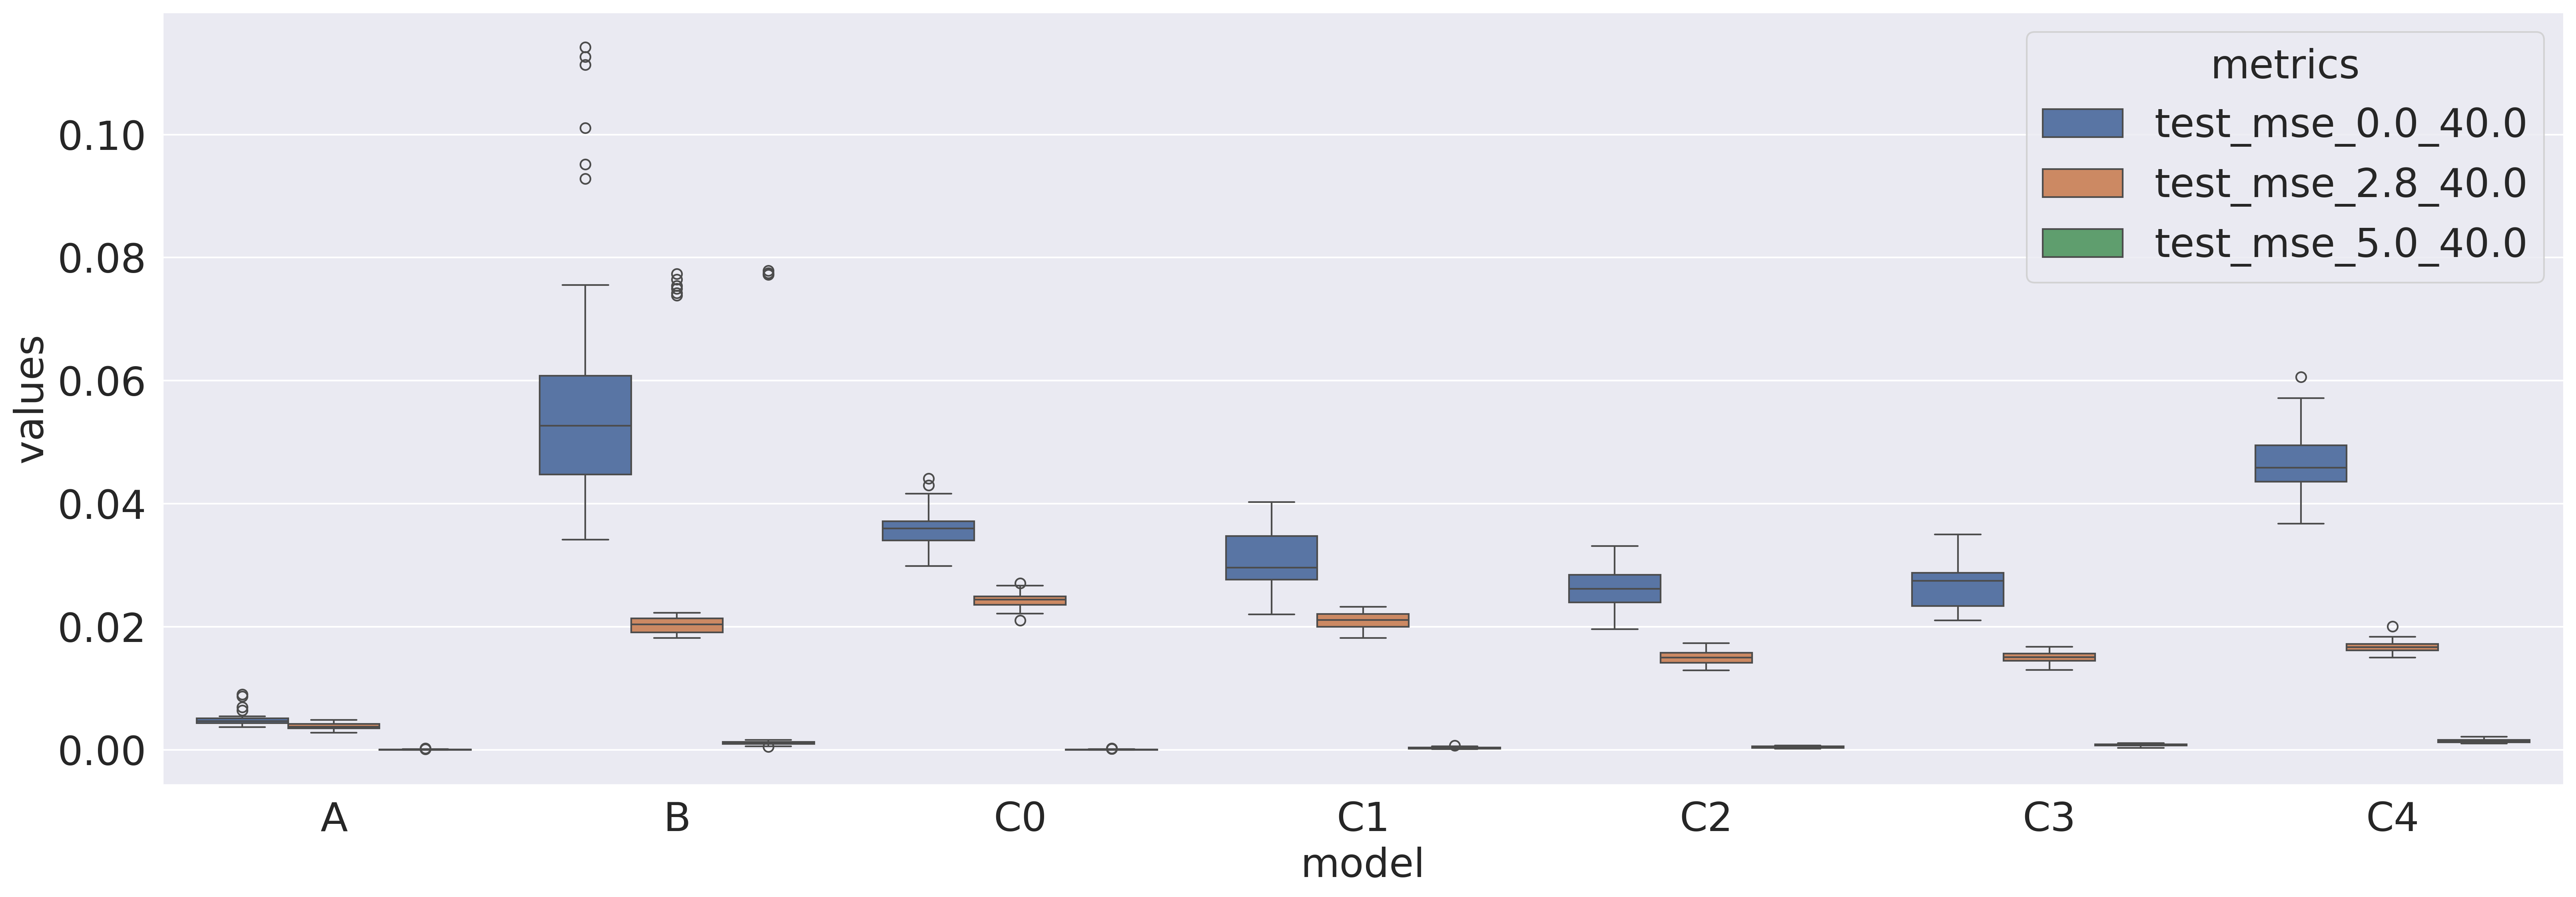

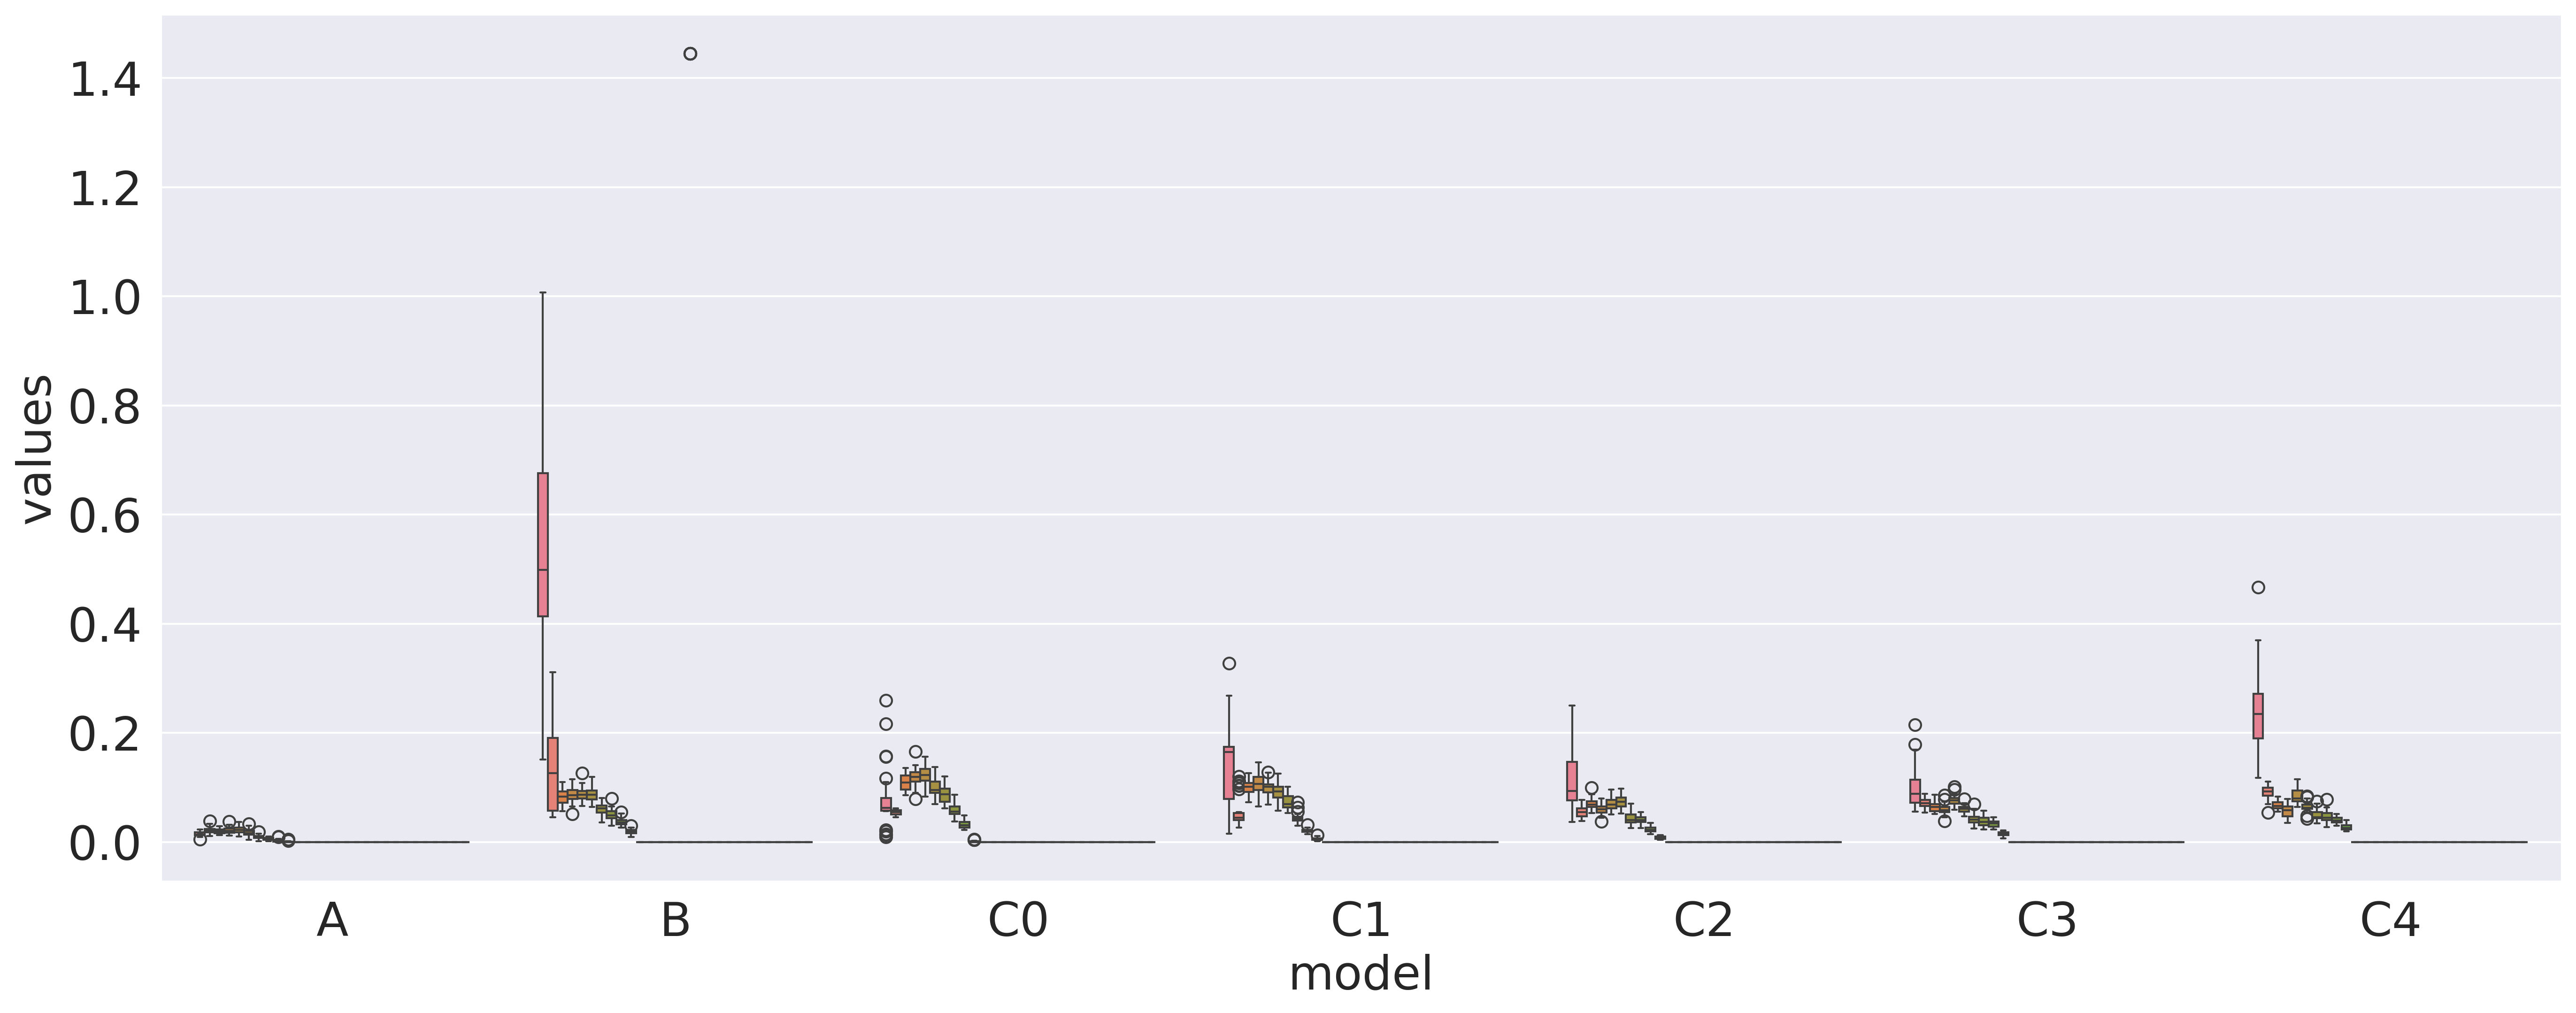

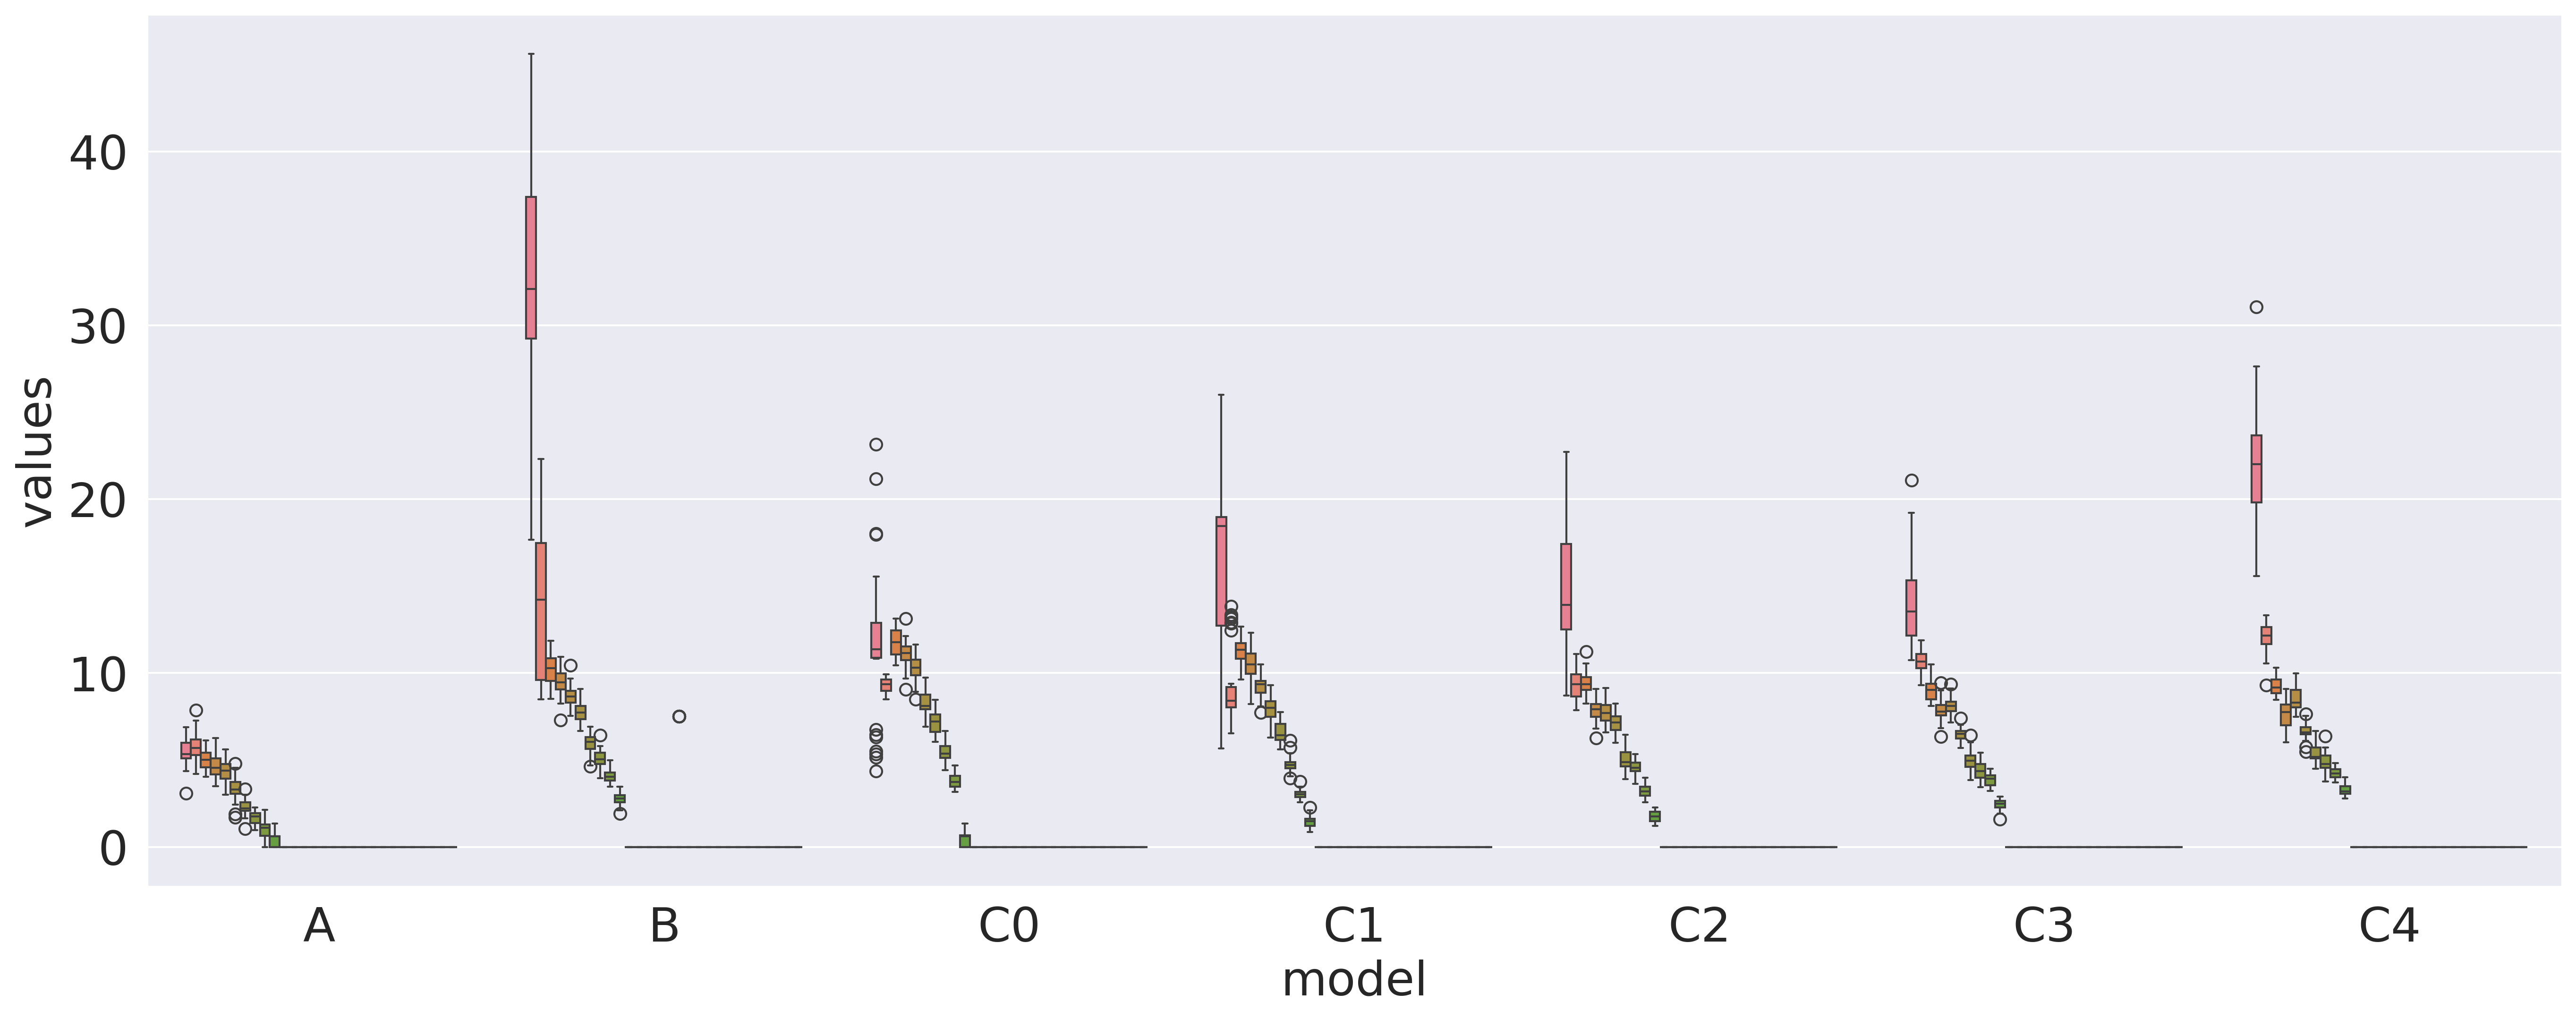

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '1.25e-04 <= y_sdv_core <= 1.01e-02 (5668)',
    'C1': '1.01e-02 <= y_sdv_core <= 2.00e-02 (5674)',
    'C2': '2.00e-02 <= y_sdv_core <= 3.00e-02 (5657)',
    'C3': '3.00e-02 <= y_sdv_core <= 3.99e-02 (5641)',
    'C4': '3.99e-02 <= y_sdv_core <= 4.99e-02 (5662)'
}

In [13]:
test_feature("y_sdv_core")

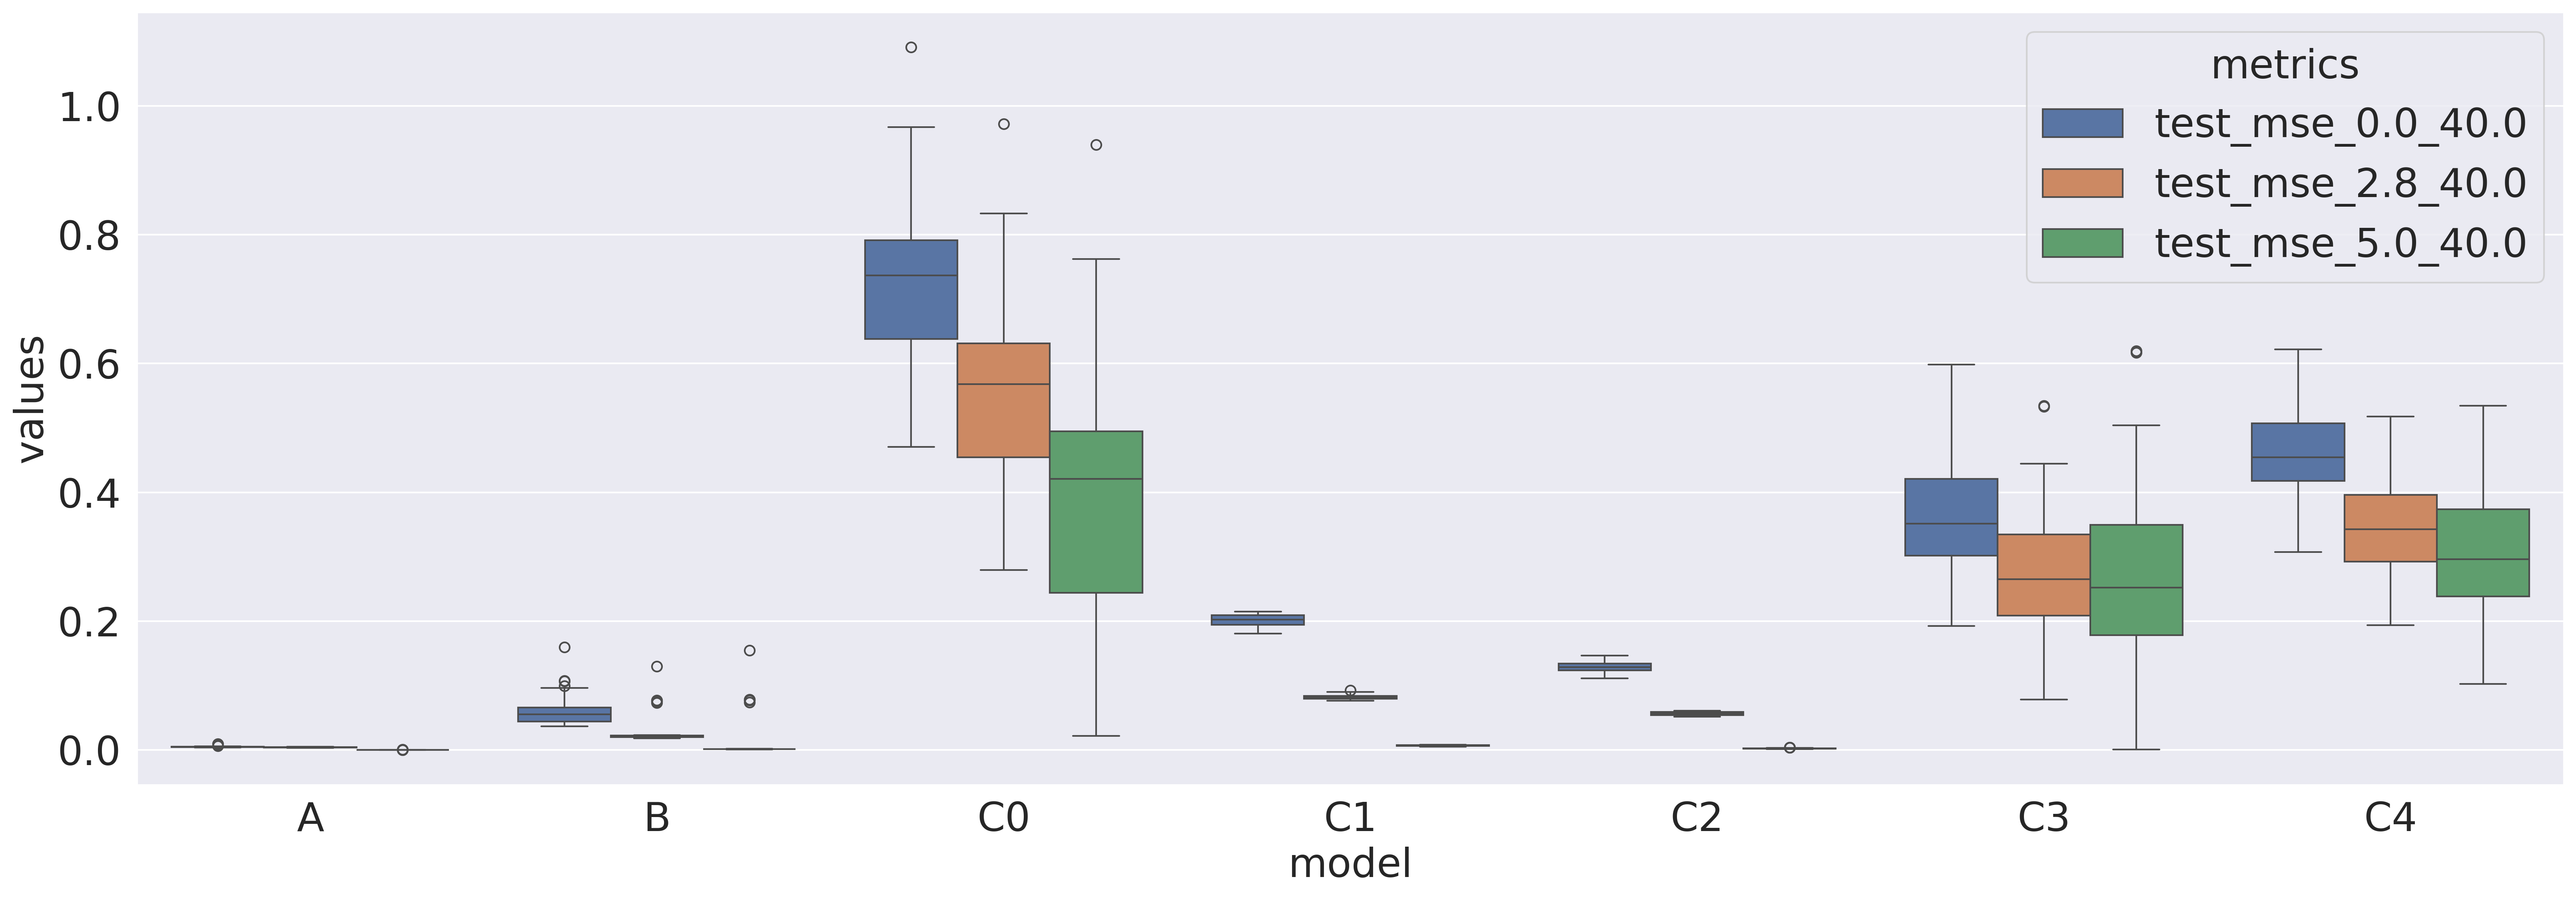

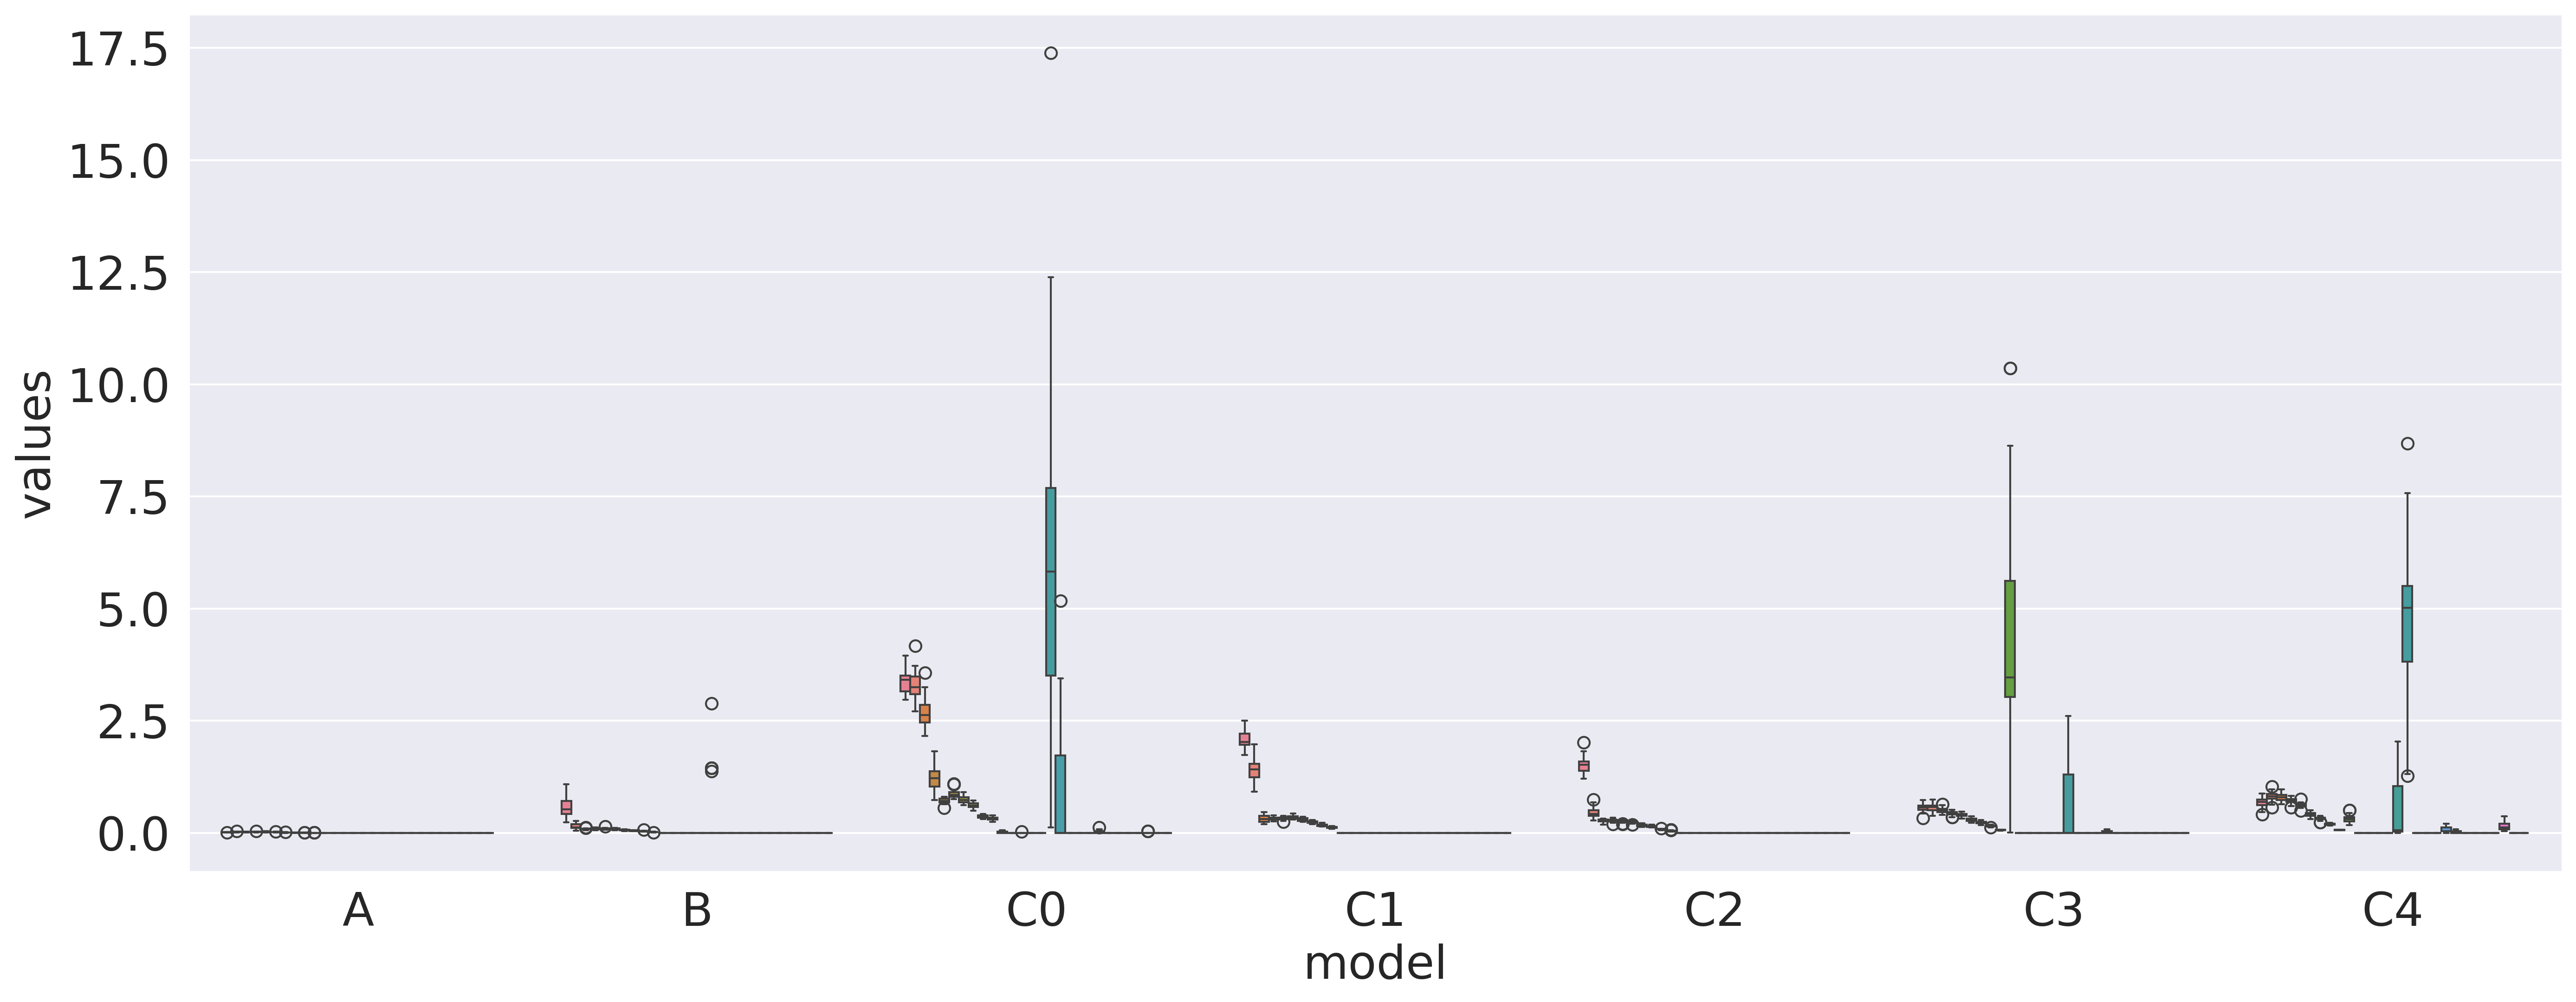

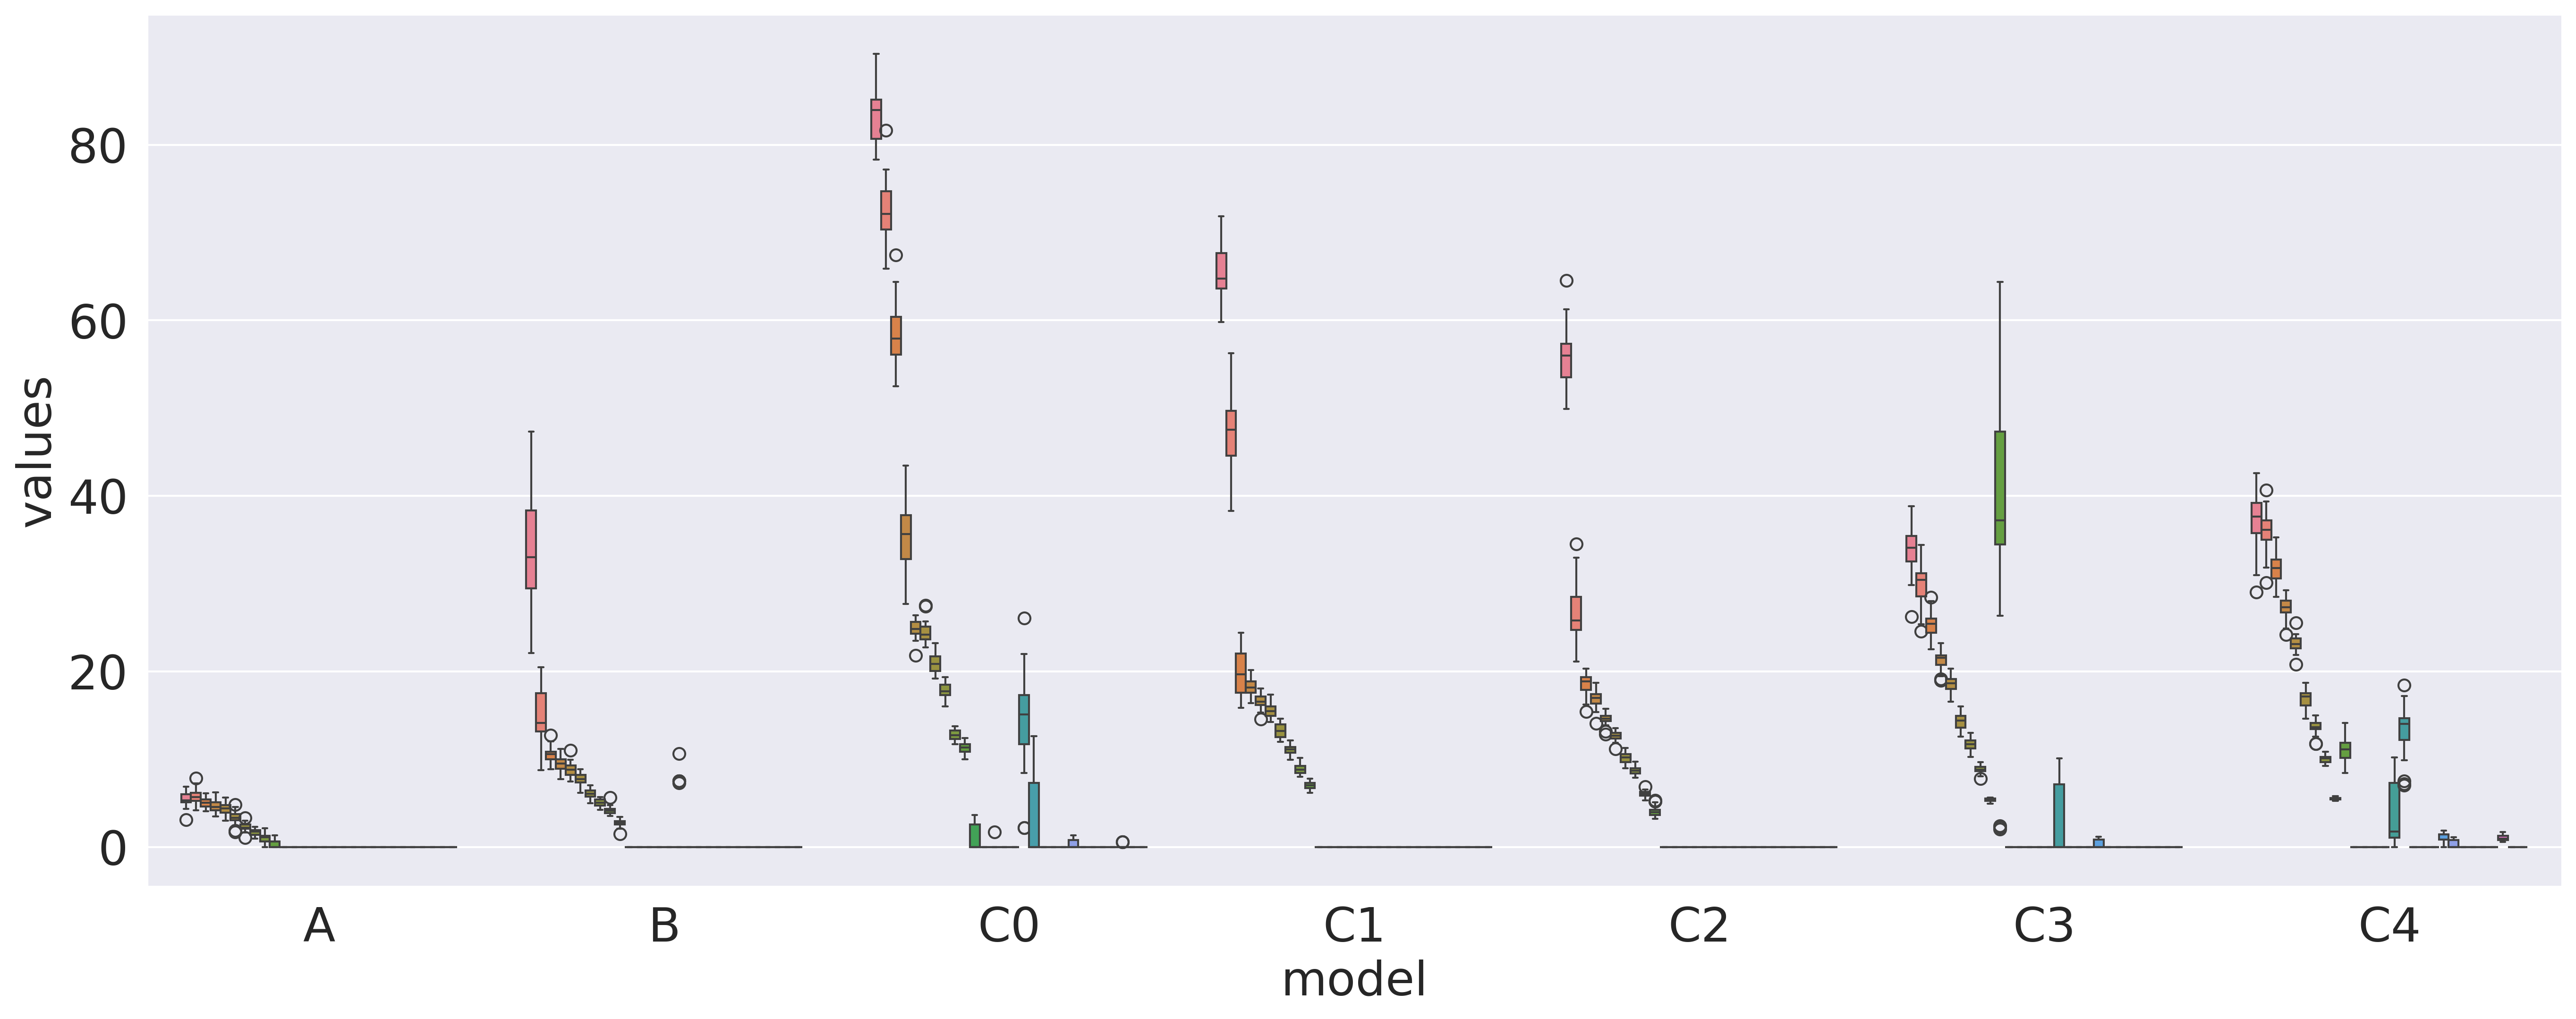

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '8.00e-01 <= y_dens_core <= 8.80e-01 (5672)',
    'C1': '8.80e-01 <= y_dens_core <= 9.60e-01 (5654)',
    'C2': '9.60e-01 <= y_dens_core <= 1.04e+00 (5663)',
    'C3': '1.04e+00 <= y_dens_core <= 1.12e+00 (5647)',
    'C4': '1.12e+00 <= y_dens_core <= 1.20e+00 (5666)'
}

In [14]:
test_feature("y_dens_core")

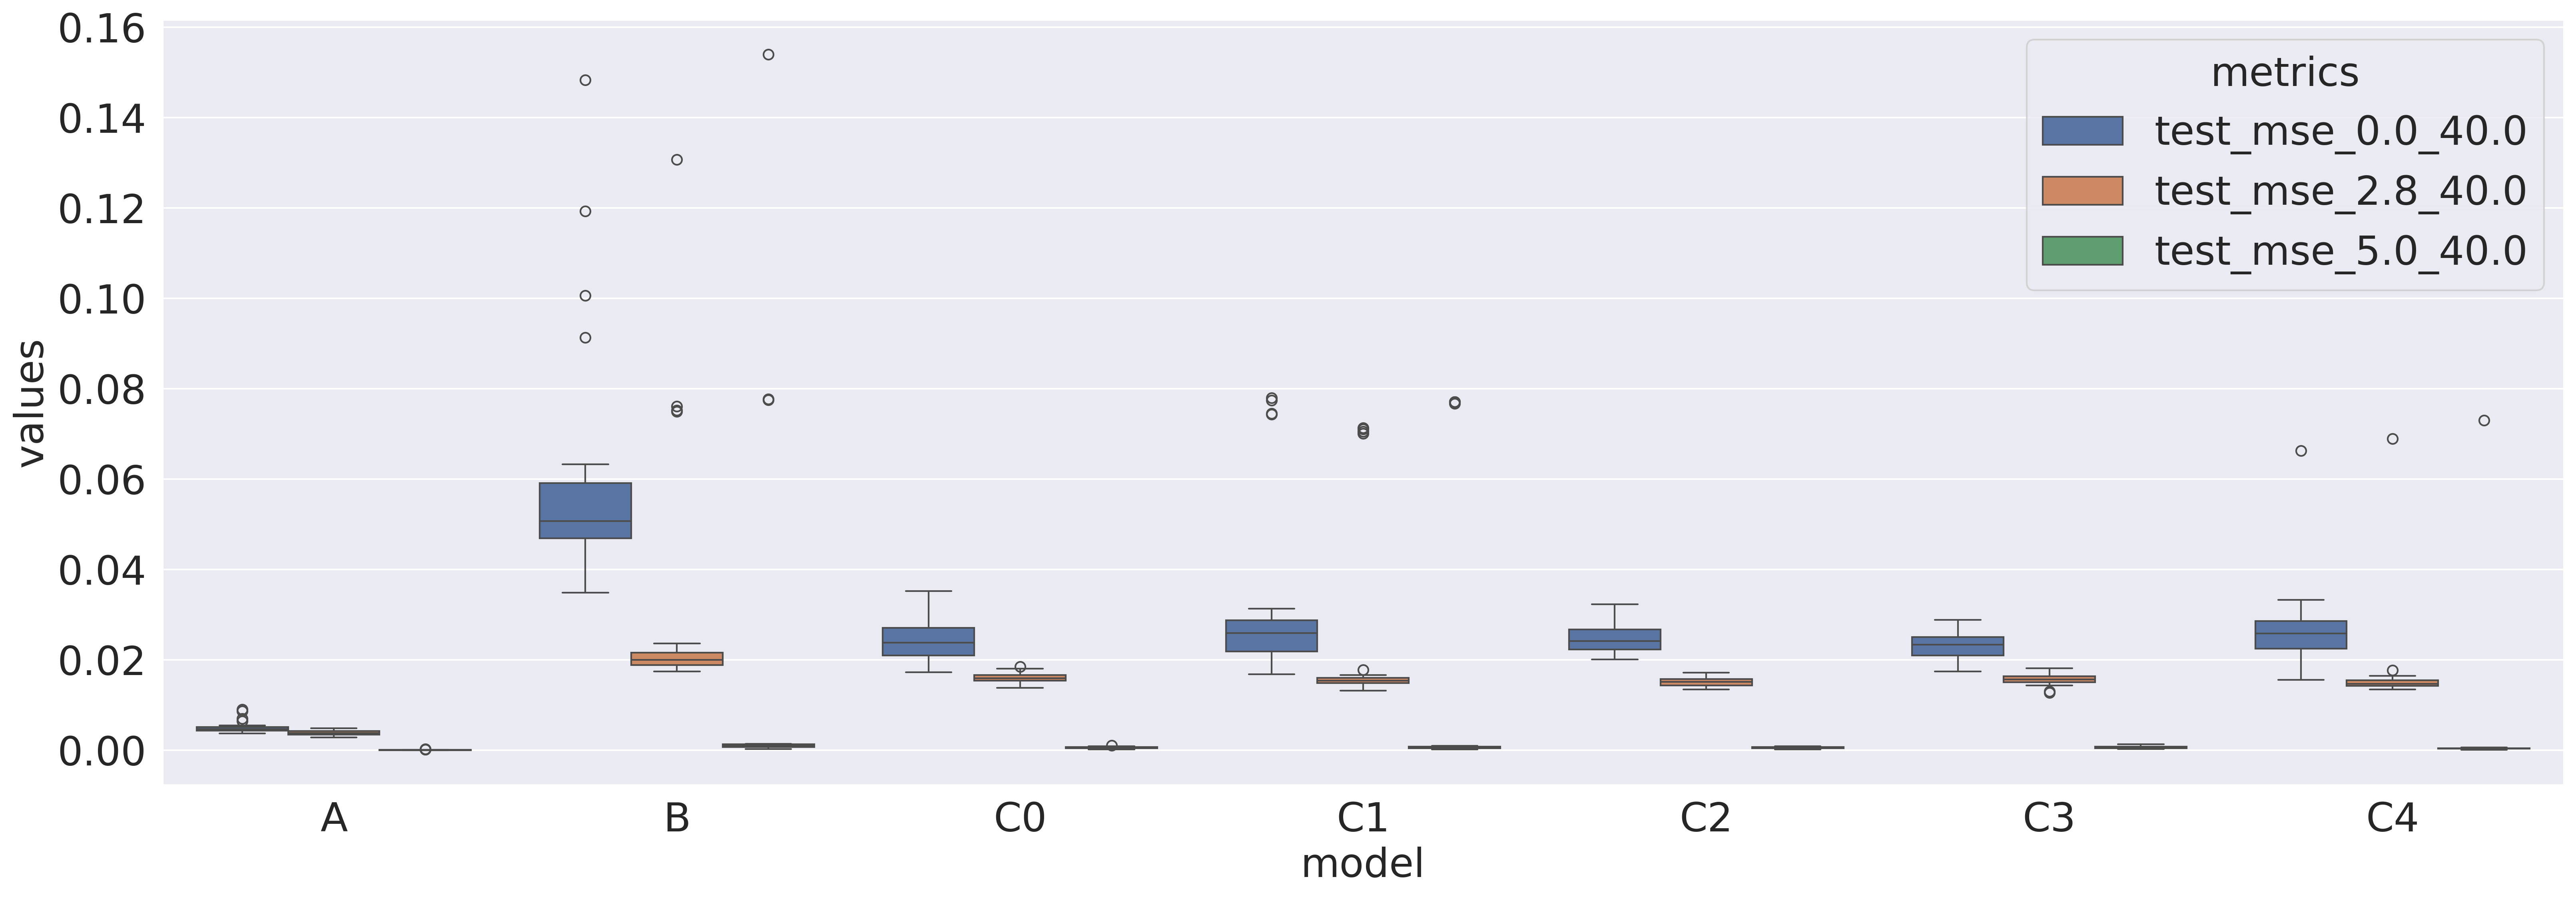

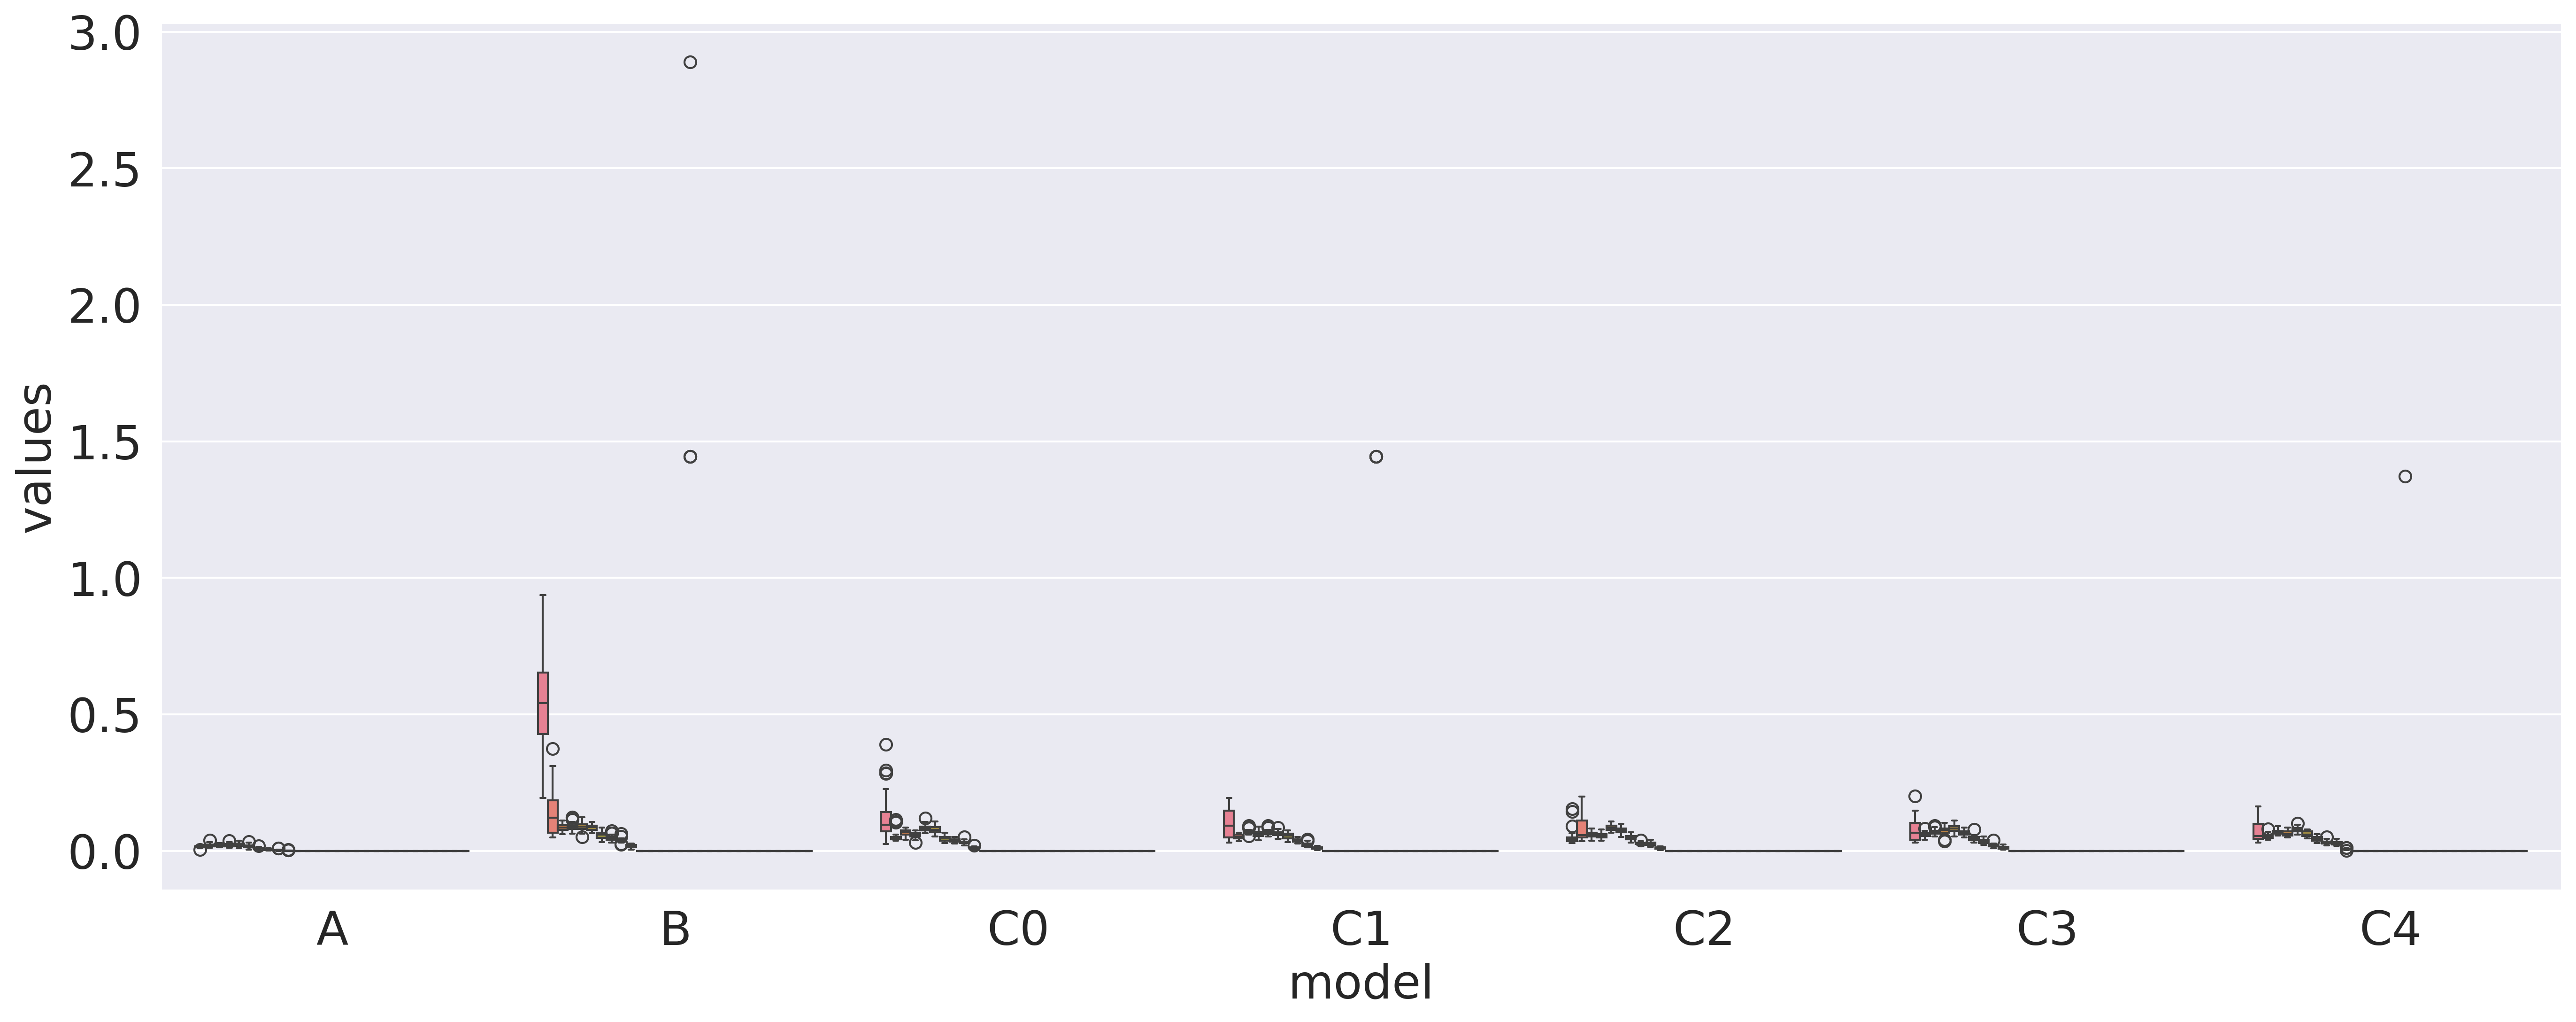

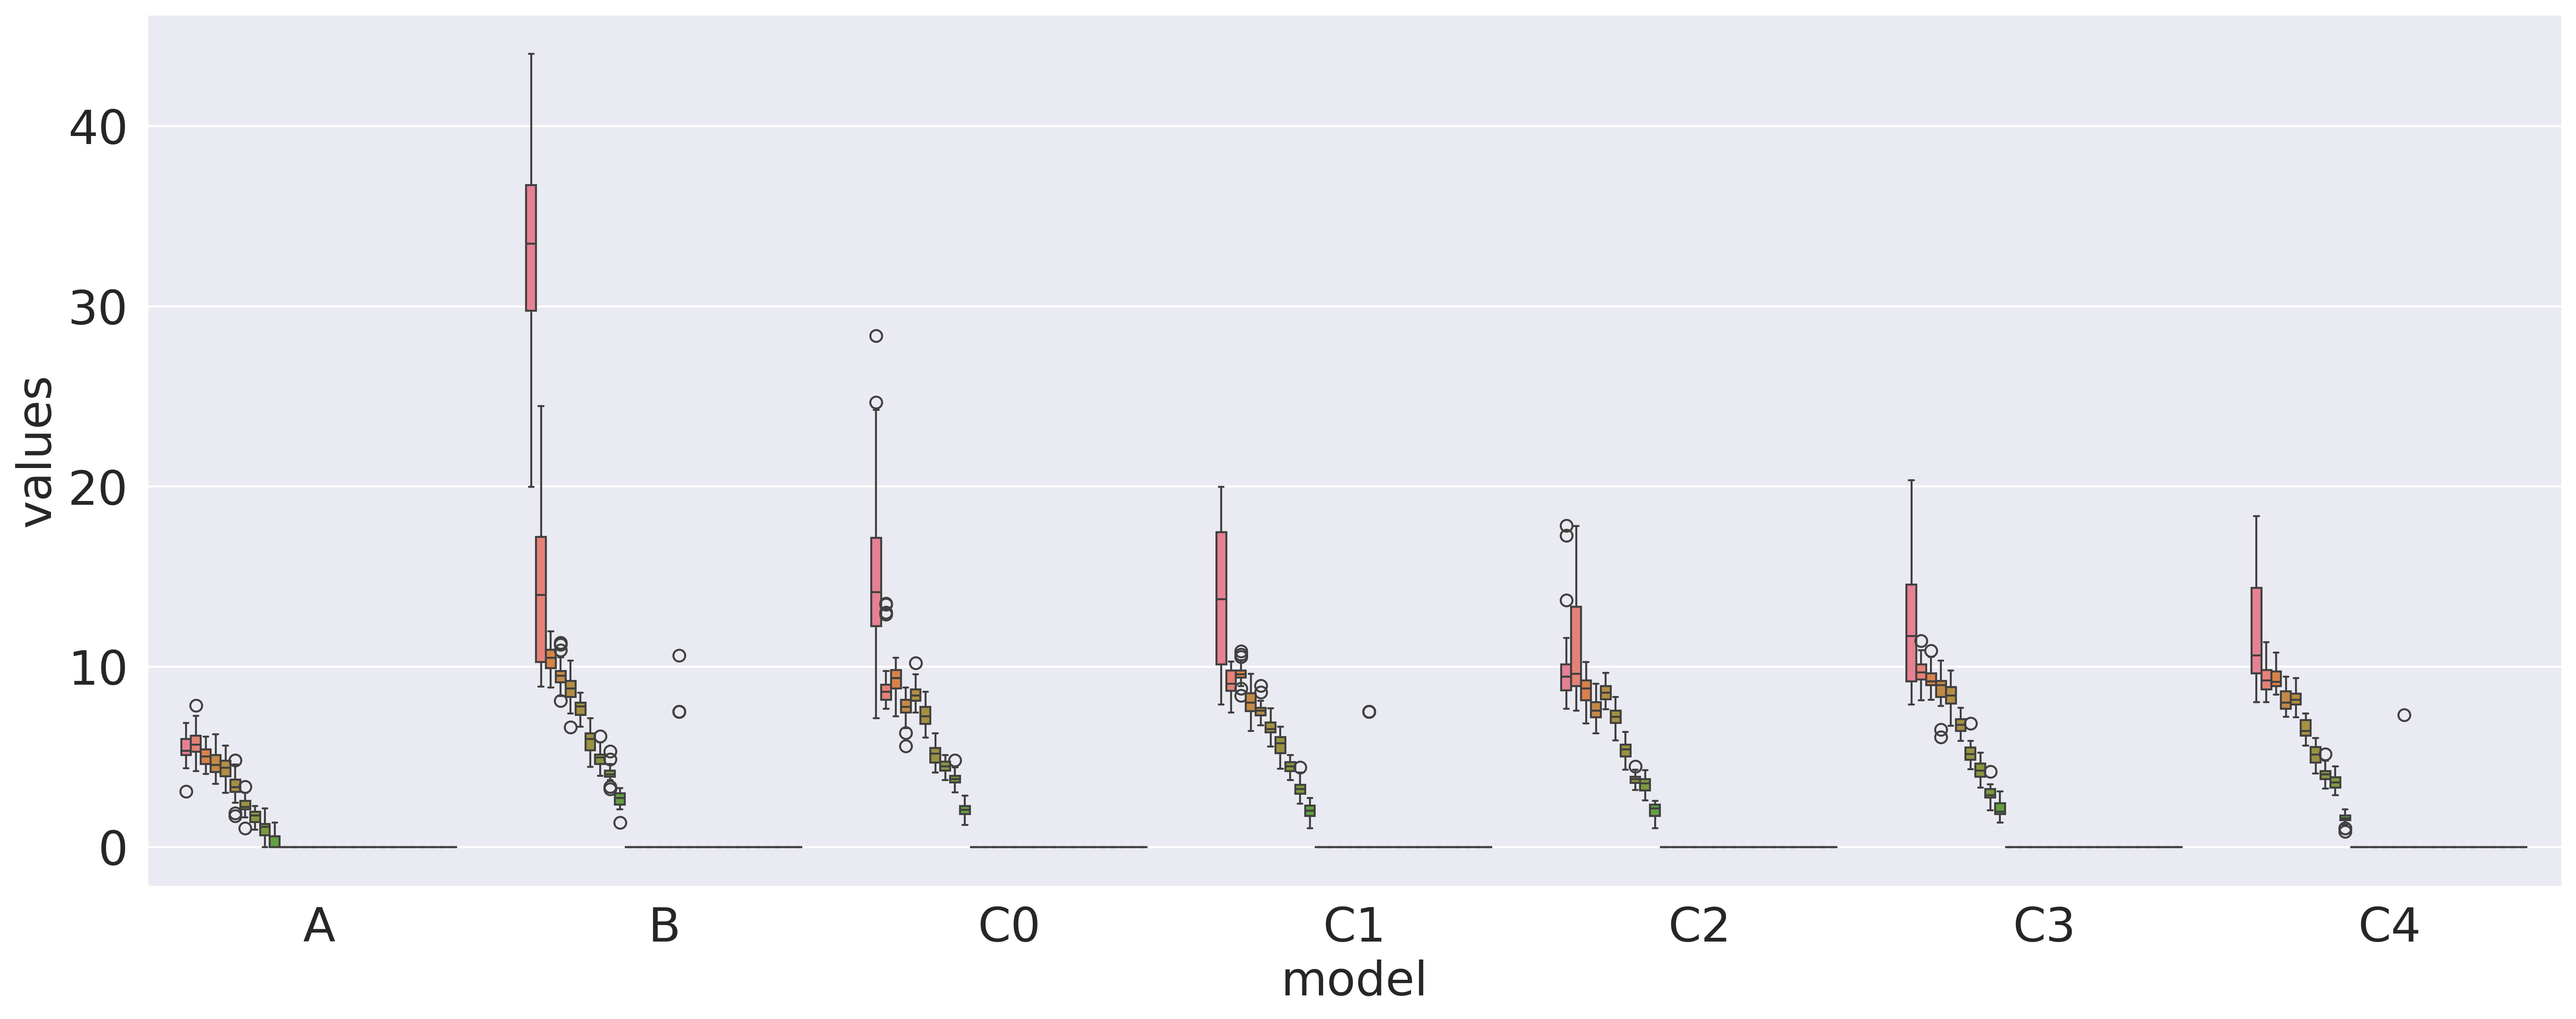

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '9.71e-01 <= y_young_fl <= 9.80e-01 (5661)',
    'C1': '9.80e-01 <= y_young_fl <= 9.89e-01 (5662)',
    'C2': '9.89e-01 <= y_young_fl <= 9.97e-01 (5657)',
    'C3': '9.97e-01 <= y_young_fl <= 1.01e+00 (5657)',
    'C4': '1.01e+00 <= y_young_fl <= 1.01e+00 (5665)'
}

In [15]:
test_feature("y_young_fl")

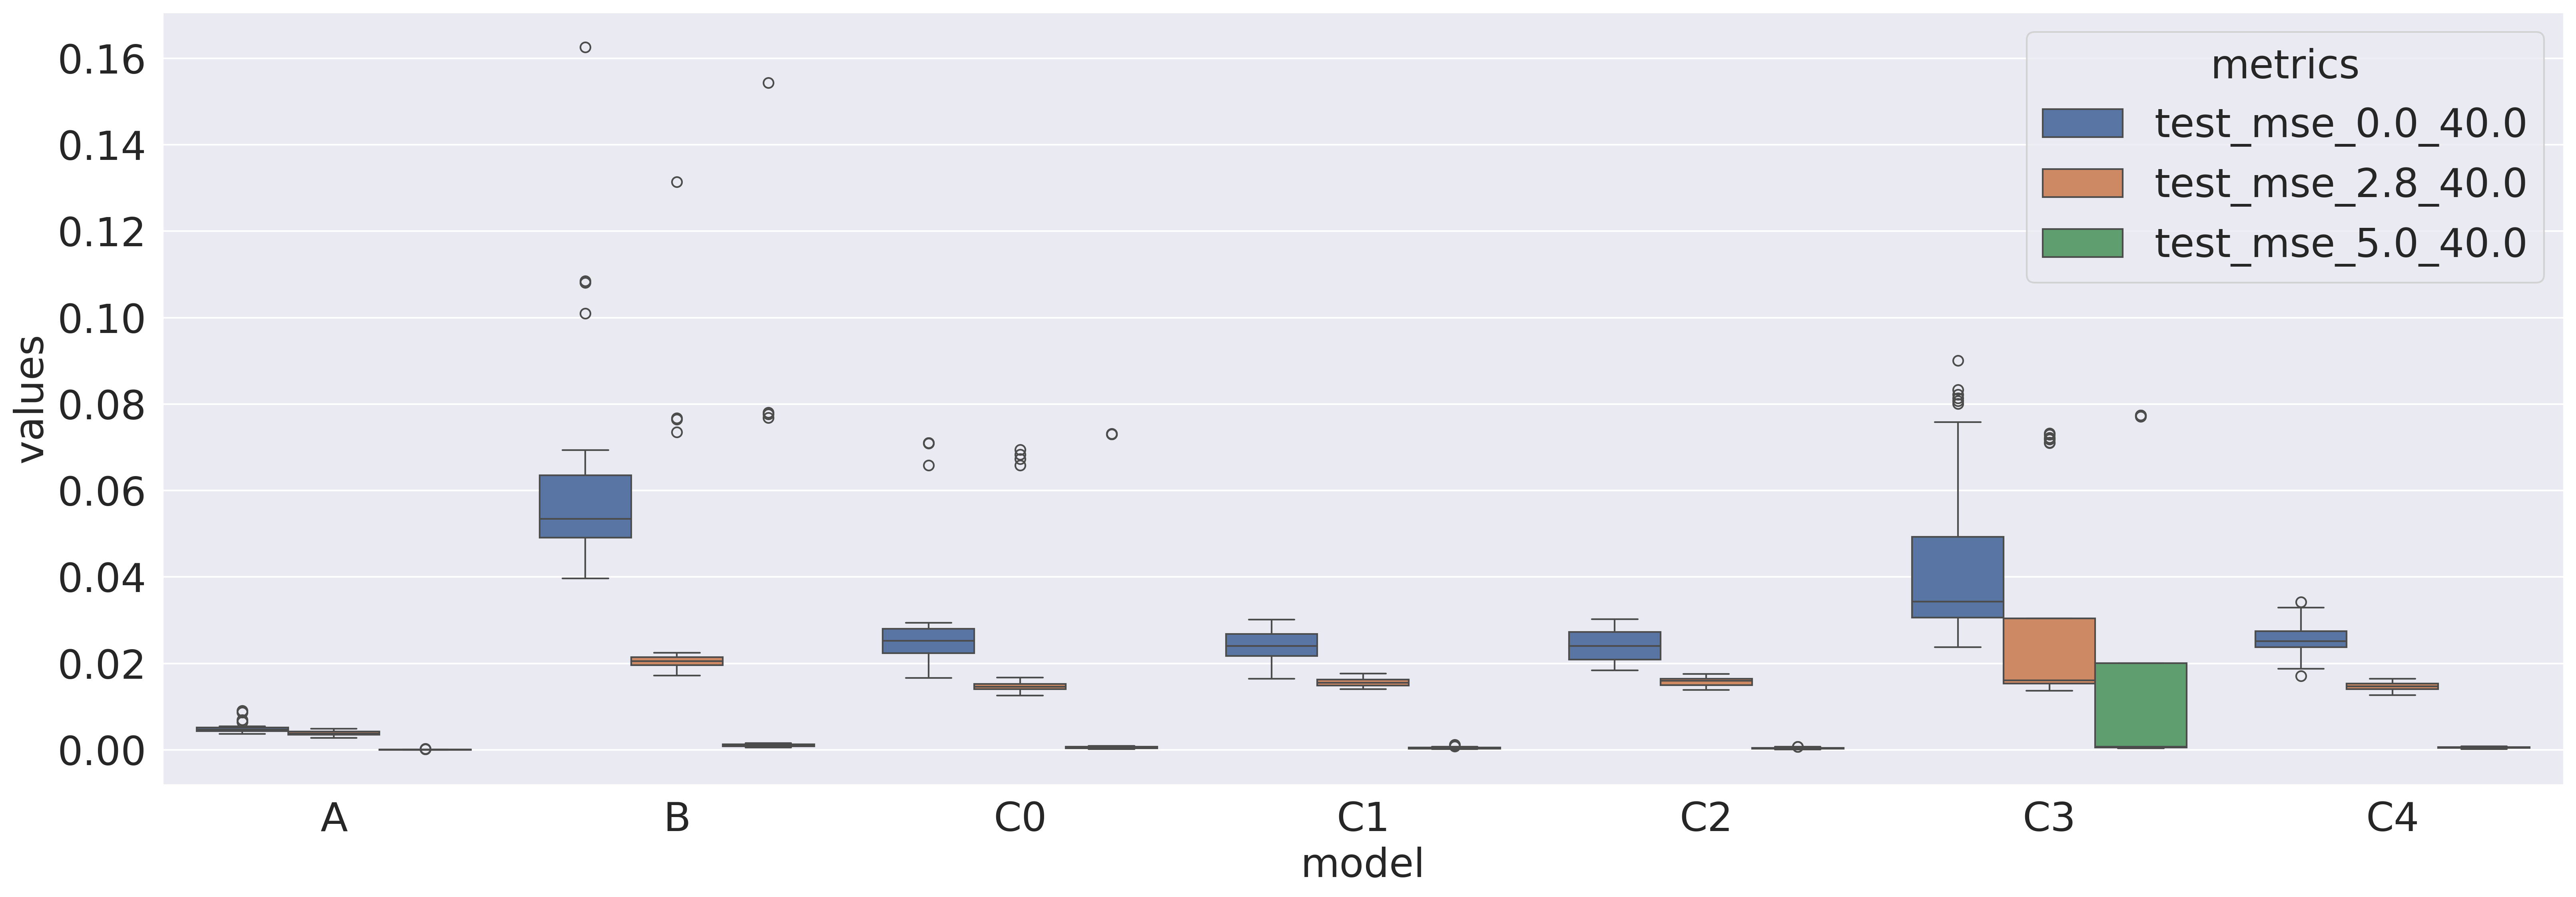

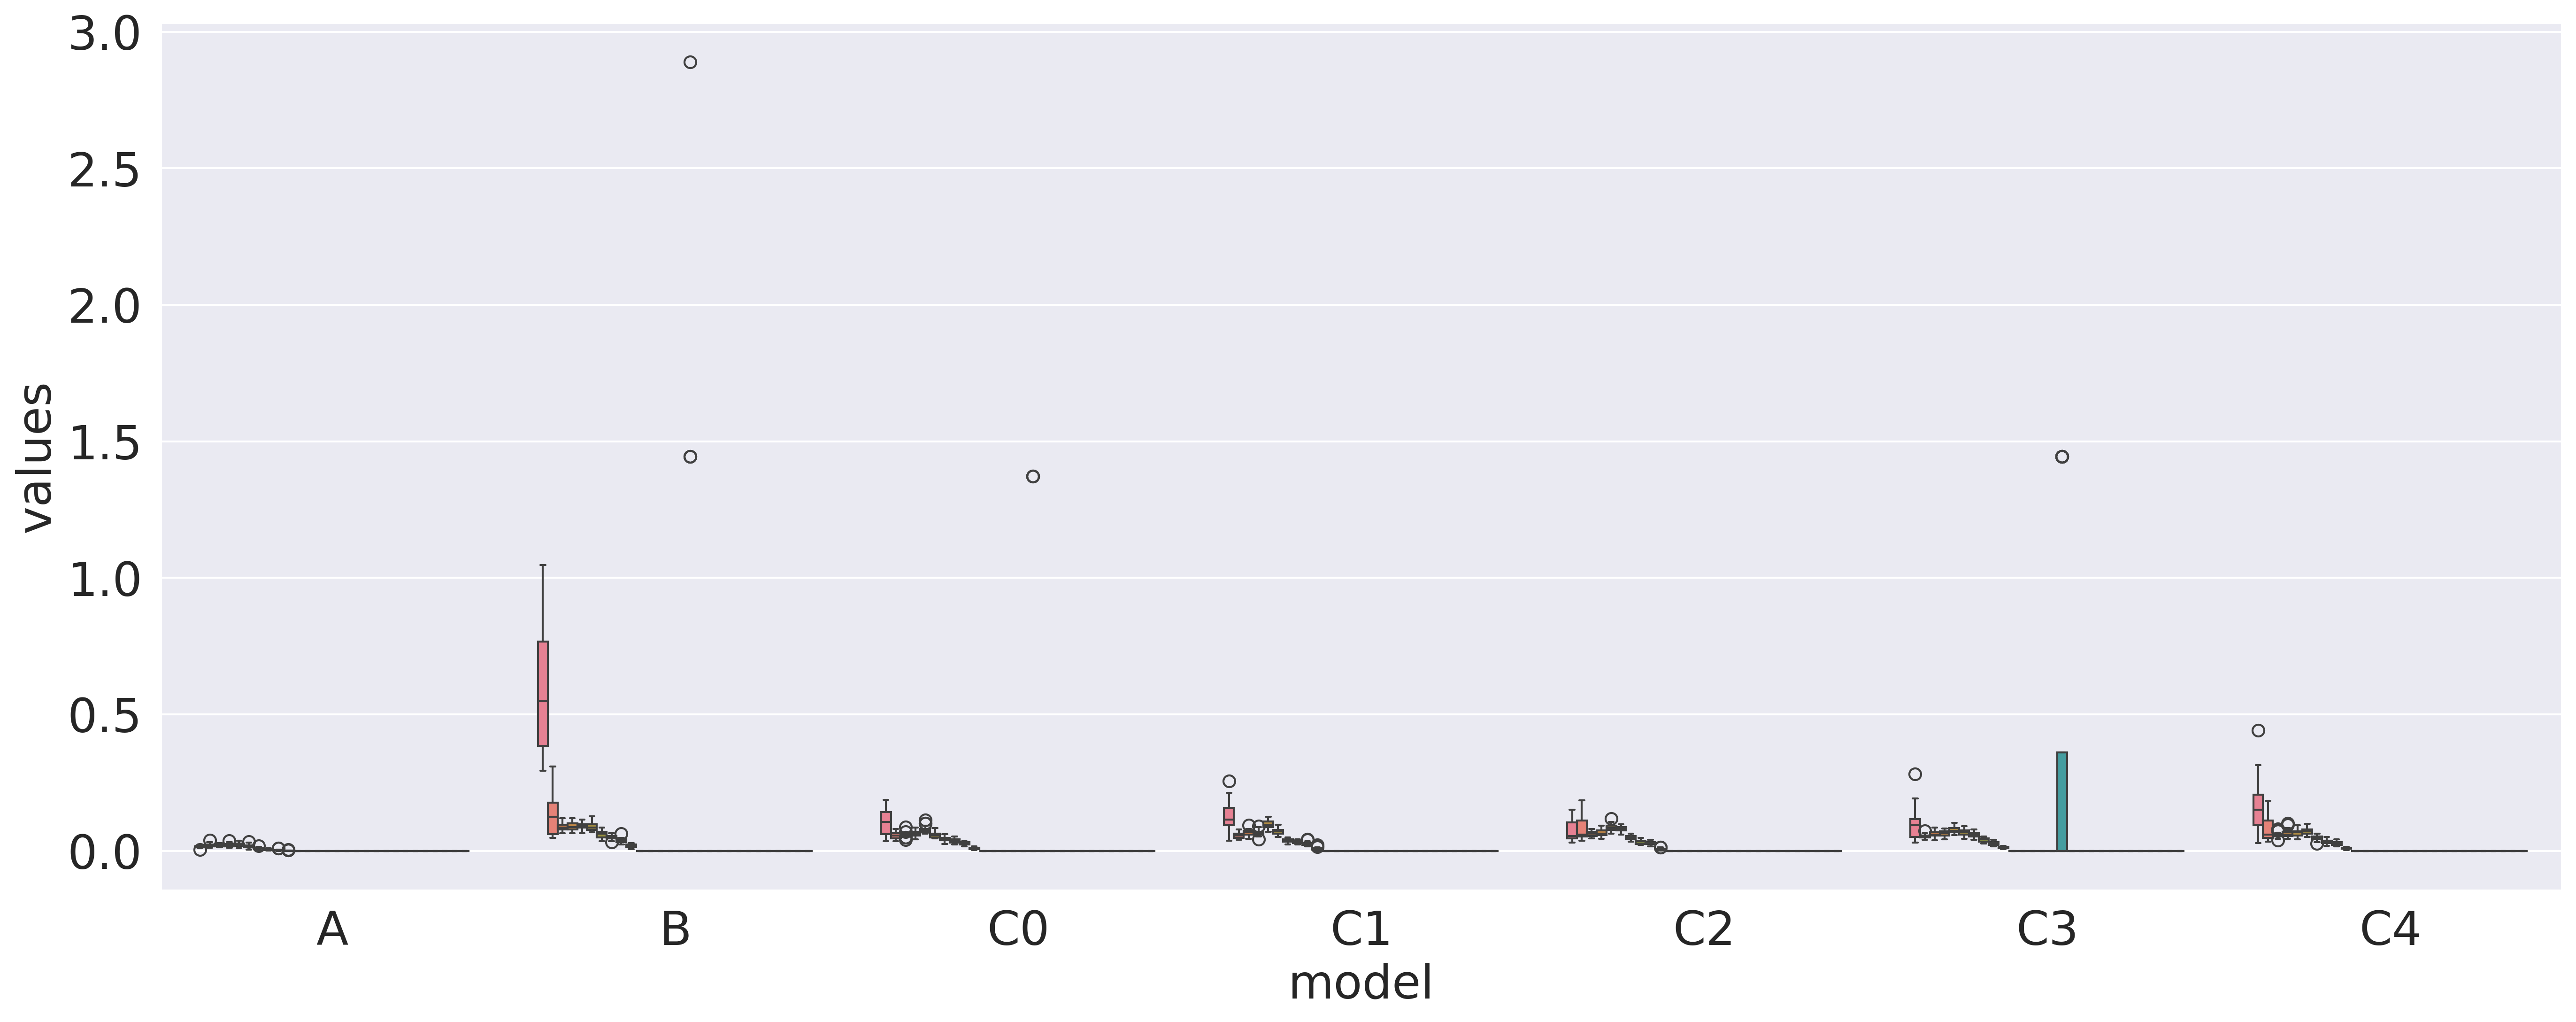

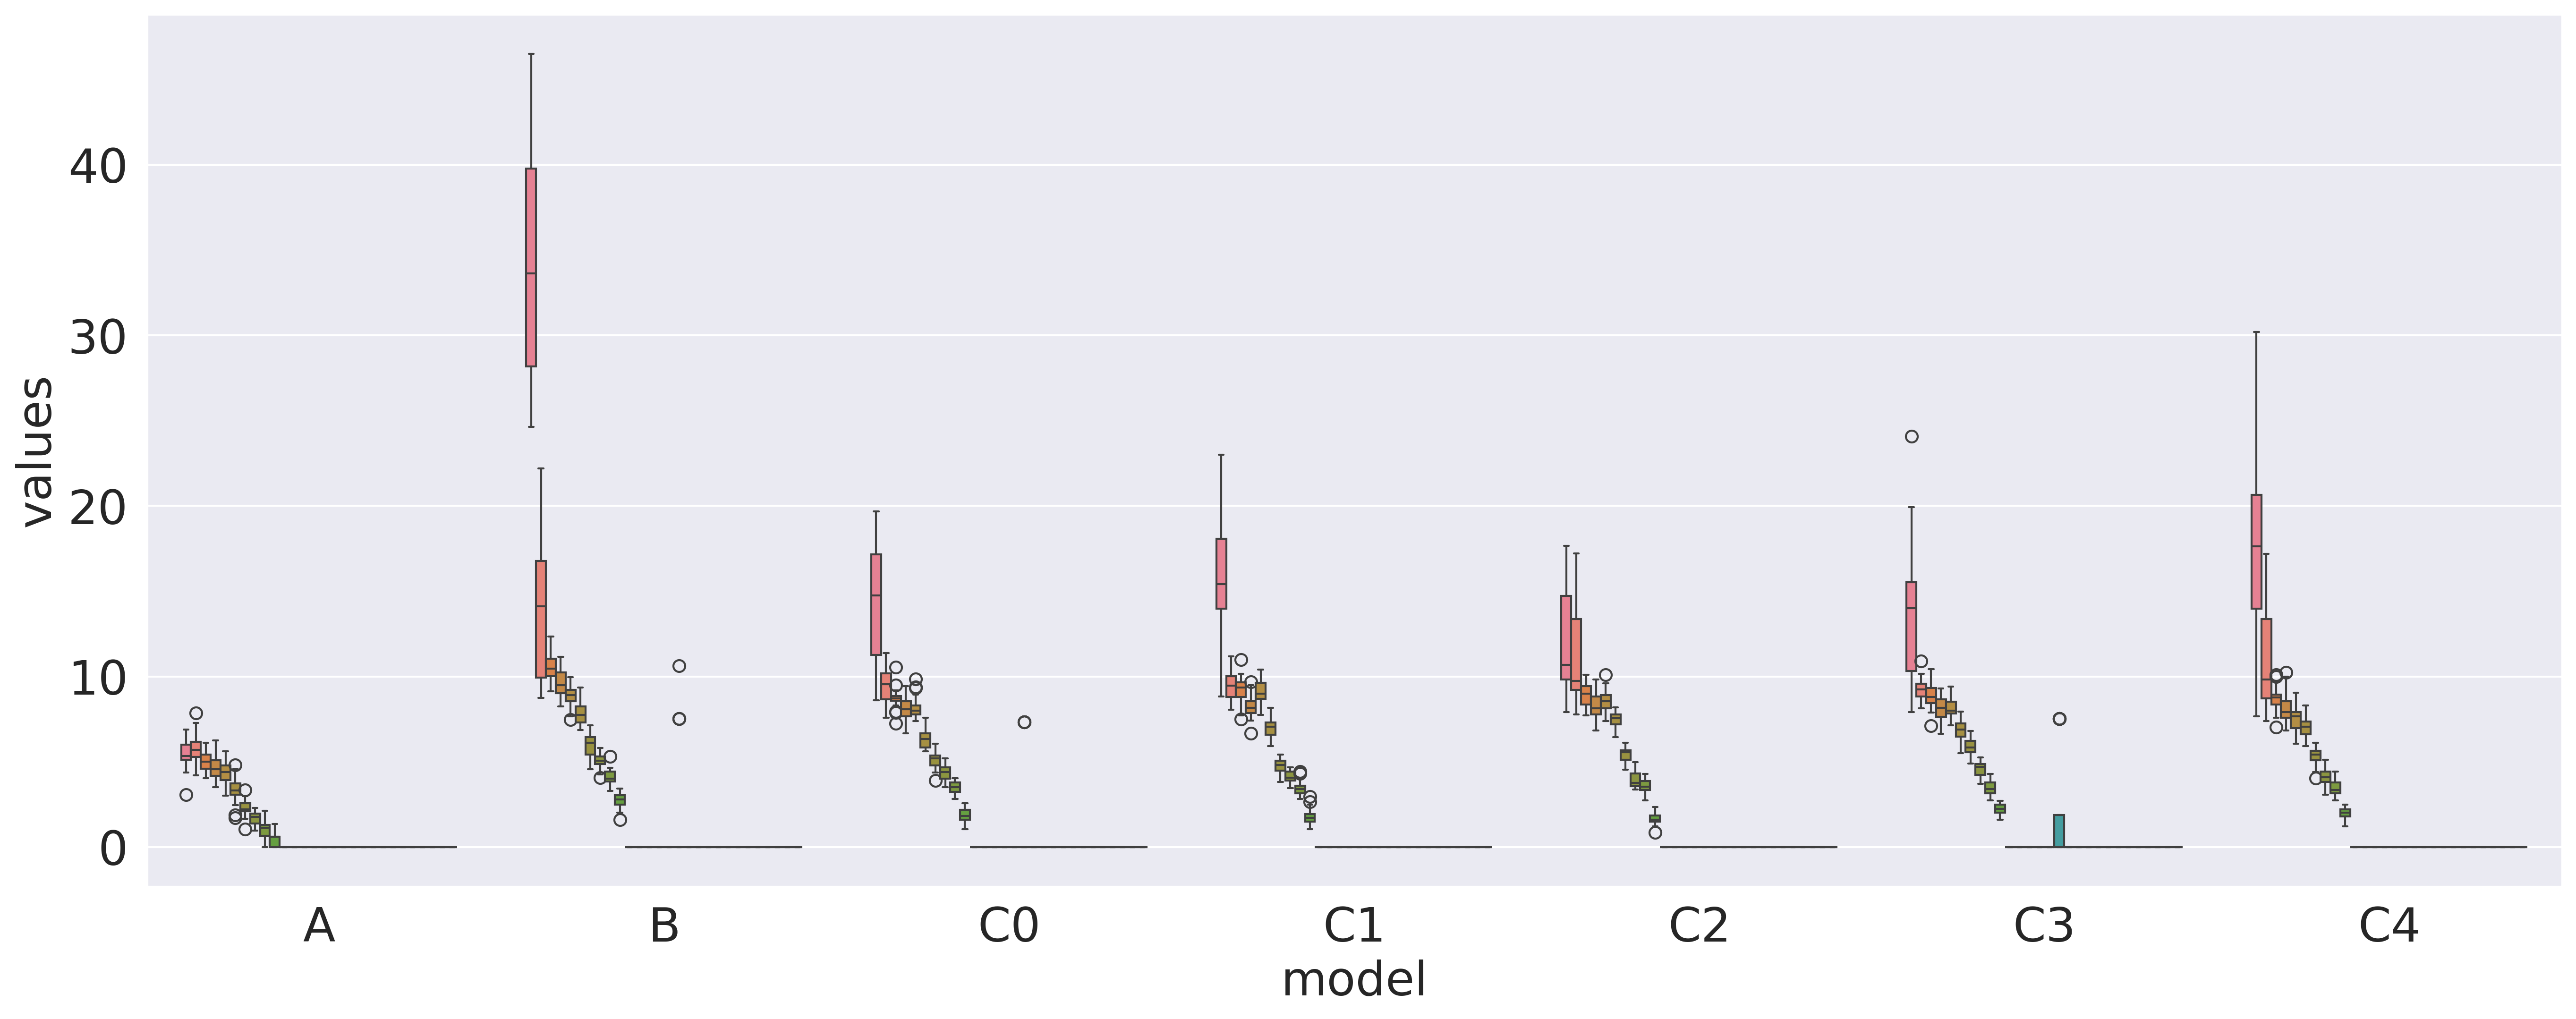

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '9.50e-01 <= y_dc <= 9.70e-01 (5677)',
    'C1': '9.70e-01 <= y_dc <= 9.90e-01 (5648)',
    'C2': '9.90e-01 <= y_dc <= 1.01e+00 (5651)',
    'C3': '1.01e+00 <= y_dc <= 1.03e+00 (5656)',
    'C4': '1.03e+00 <= y_dc <= 1.05e+00 (5670)'
}

In [16]:
test_feature("y_dc")

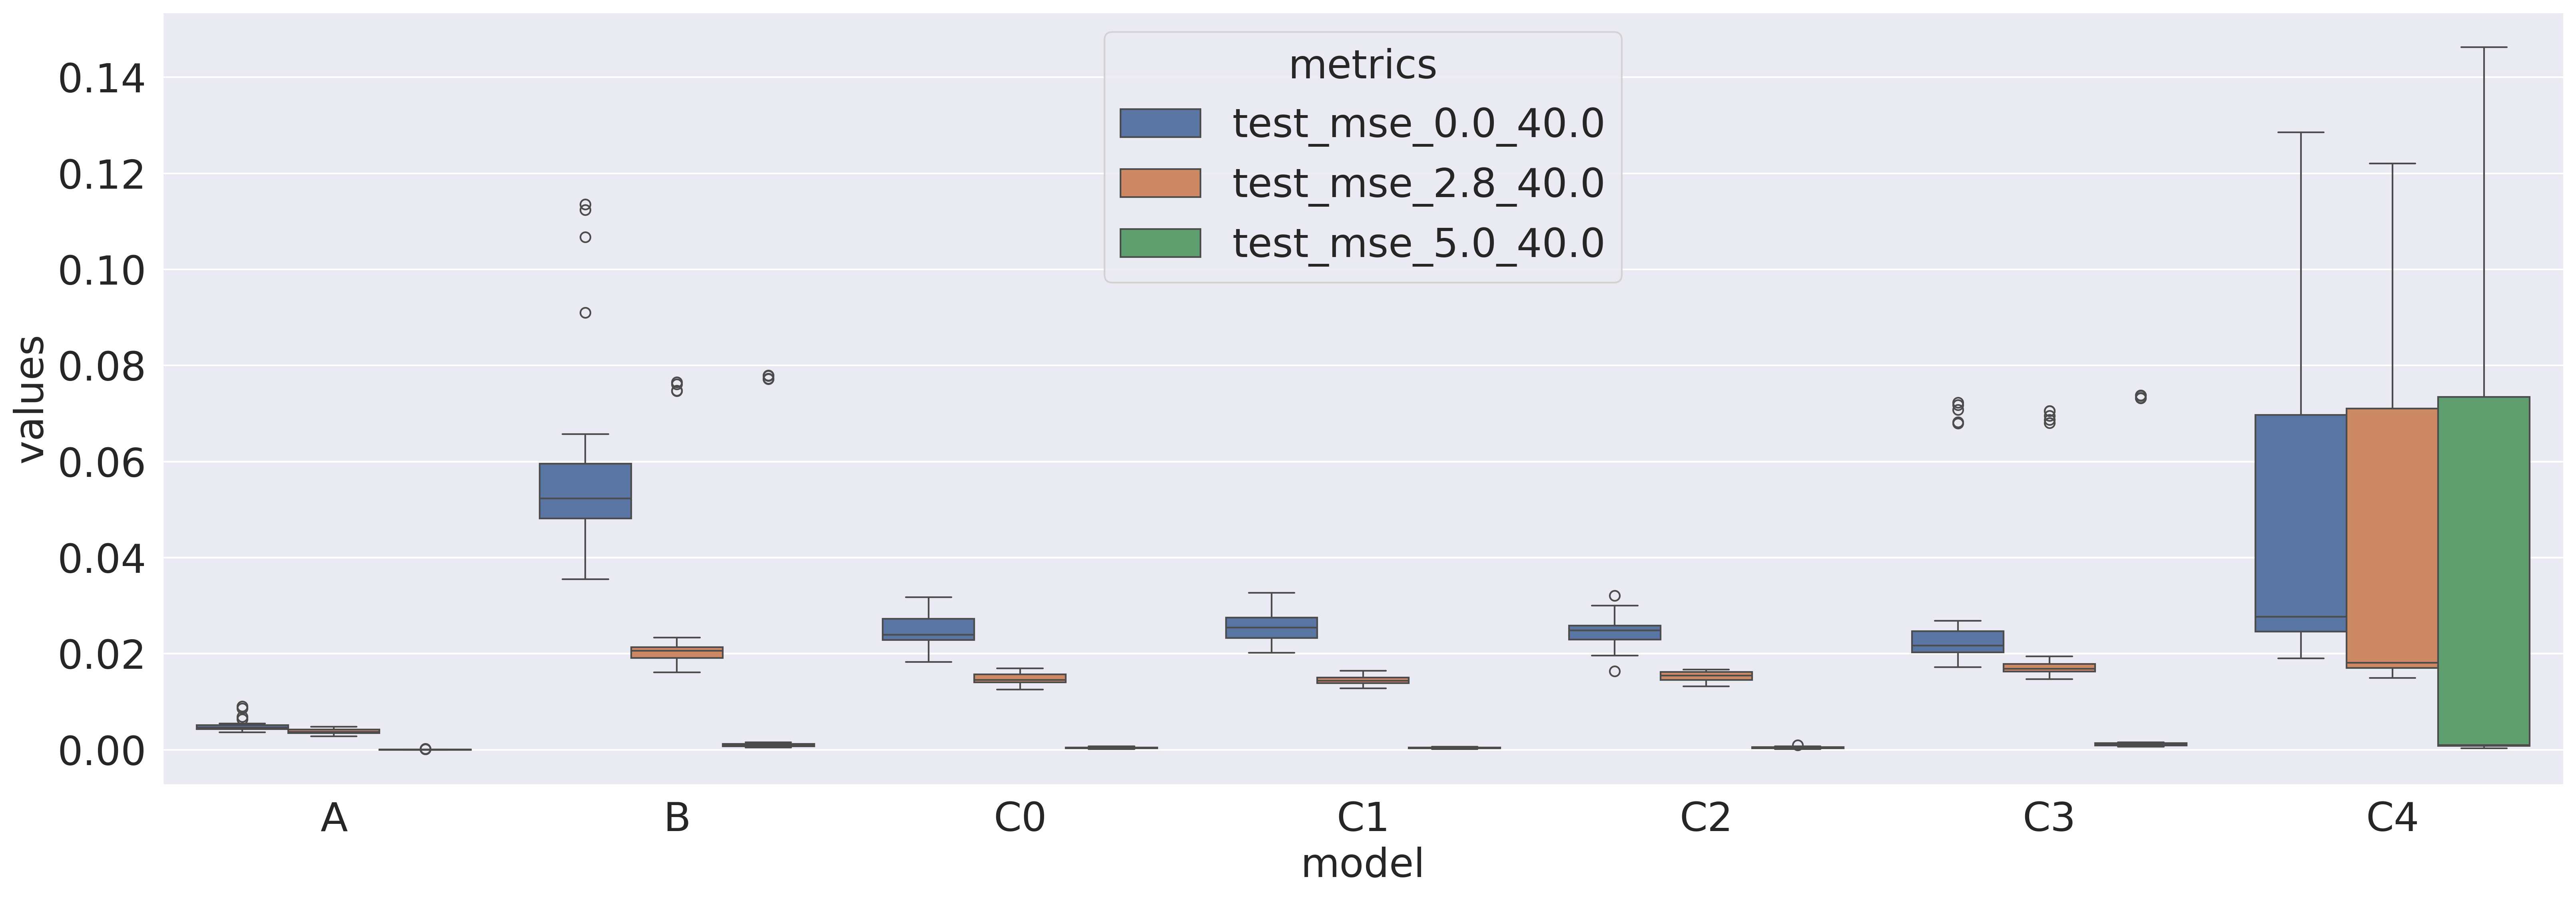

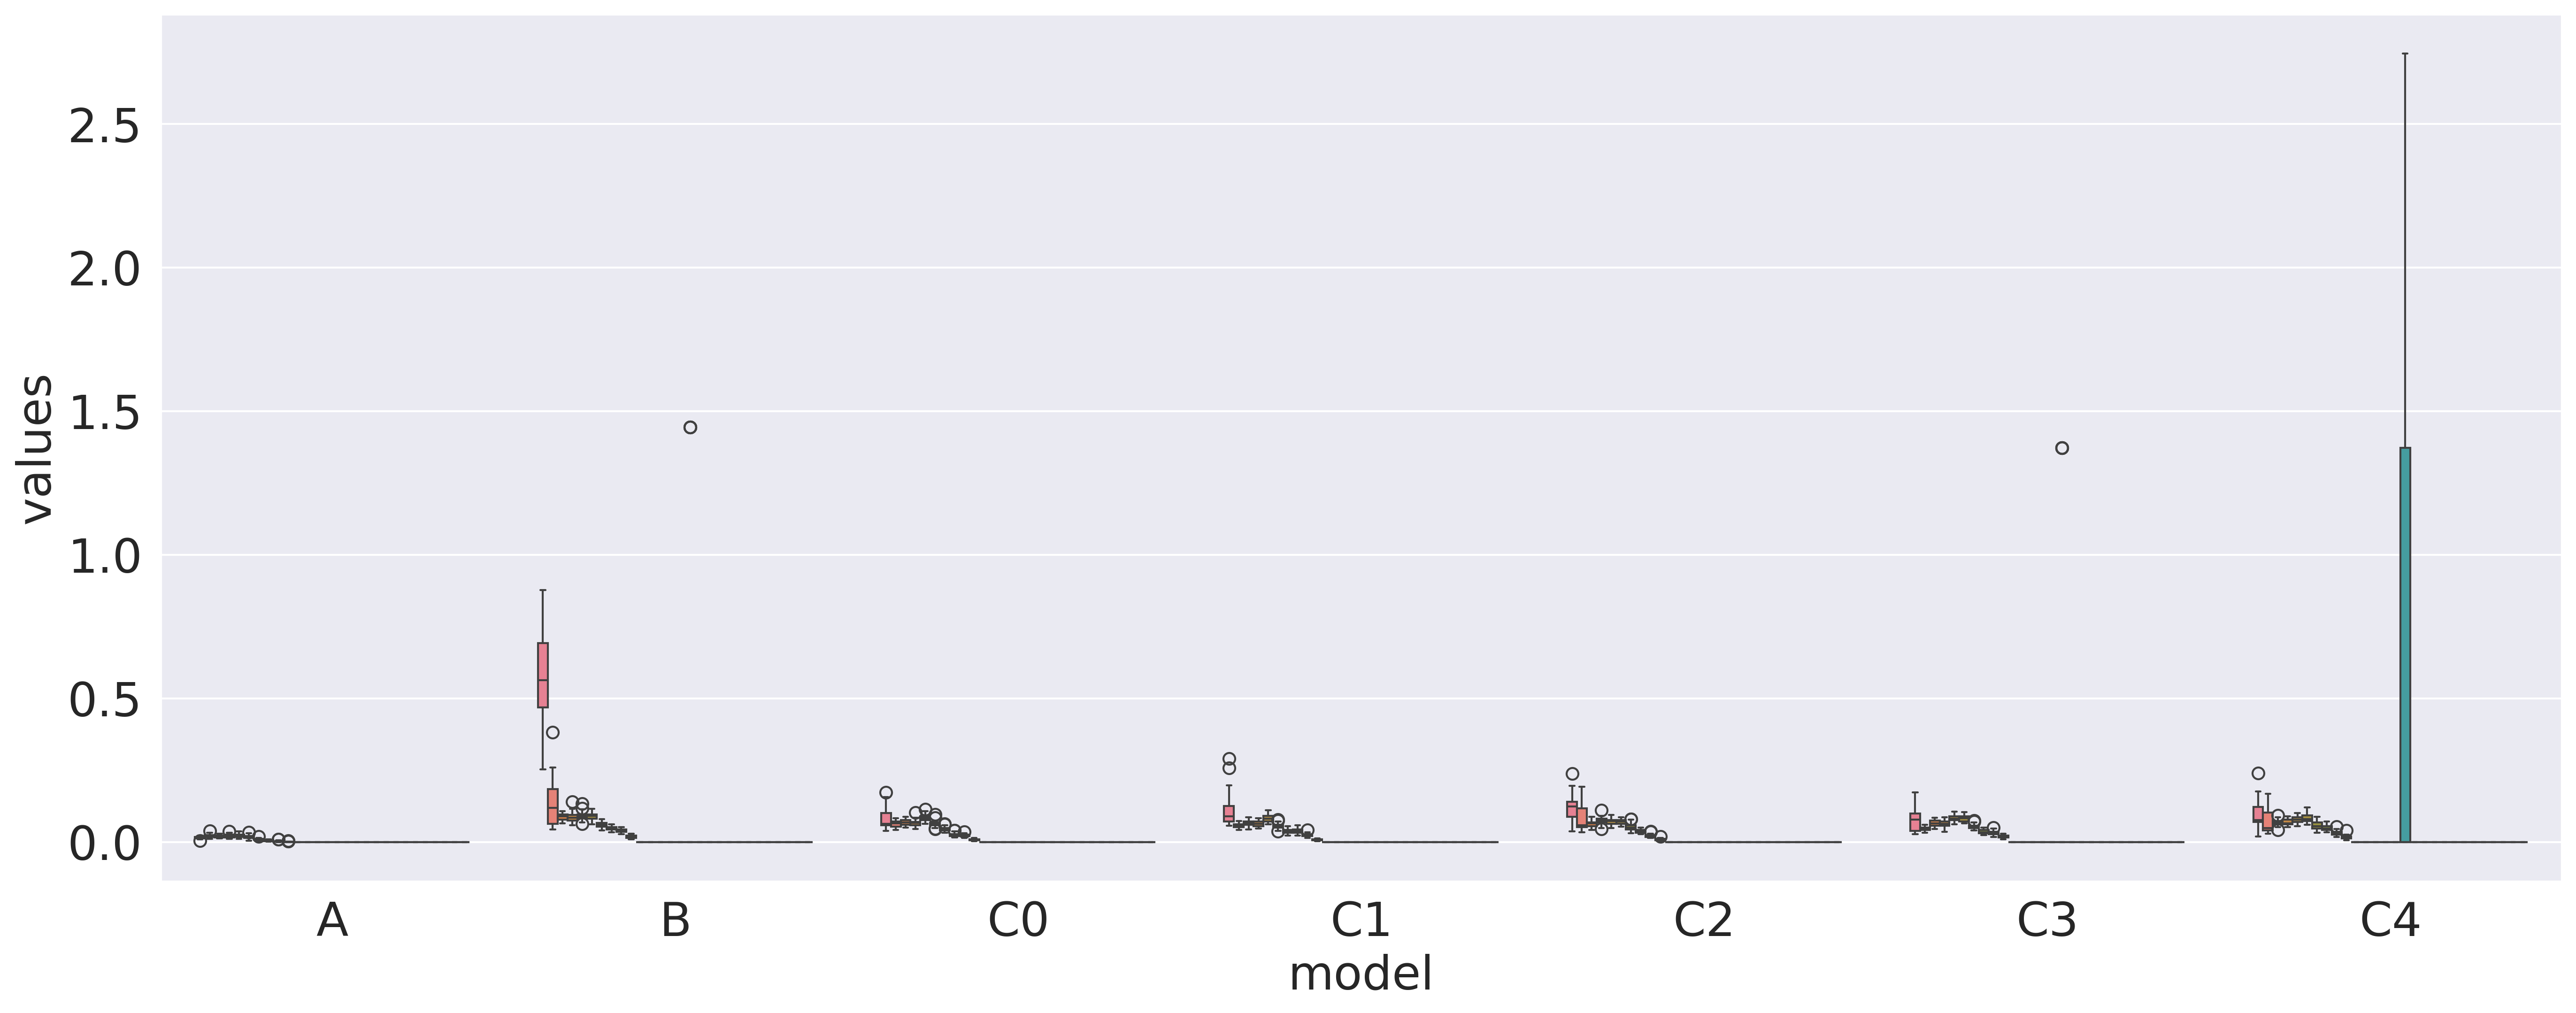

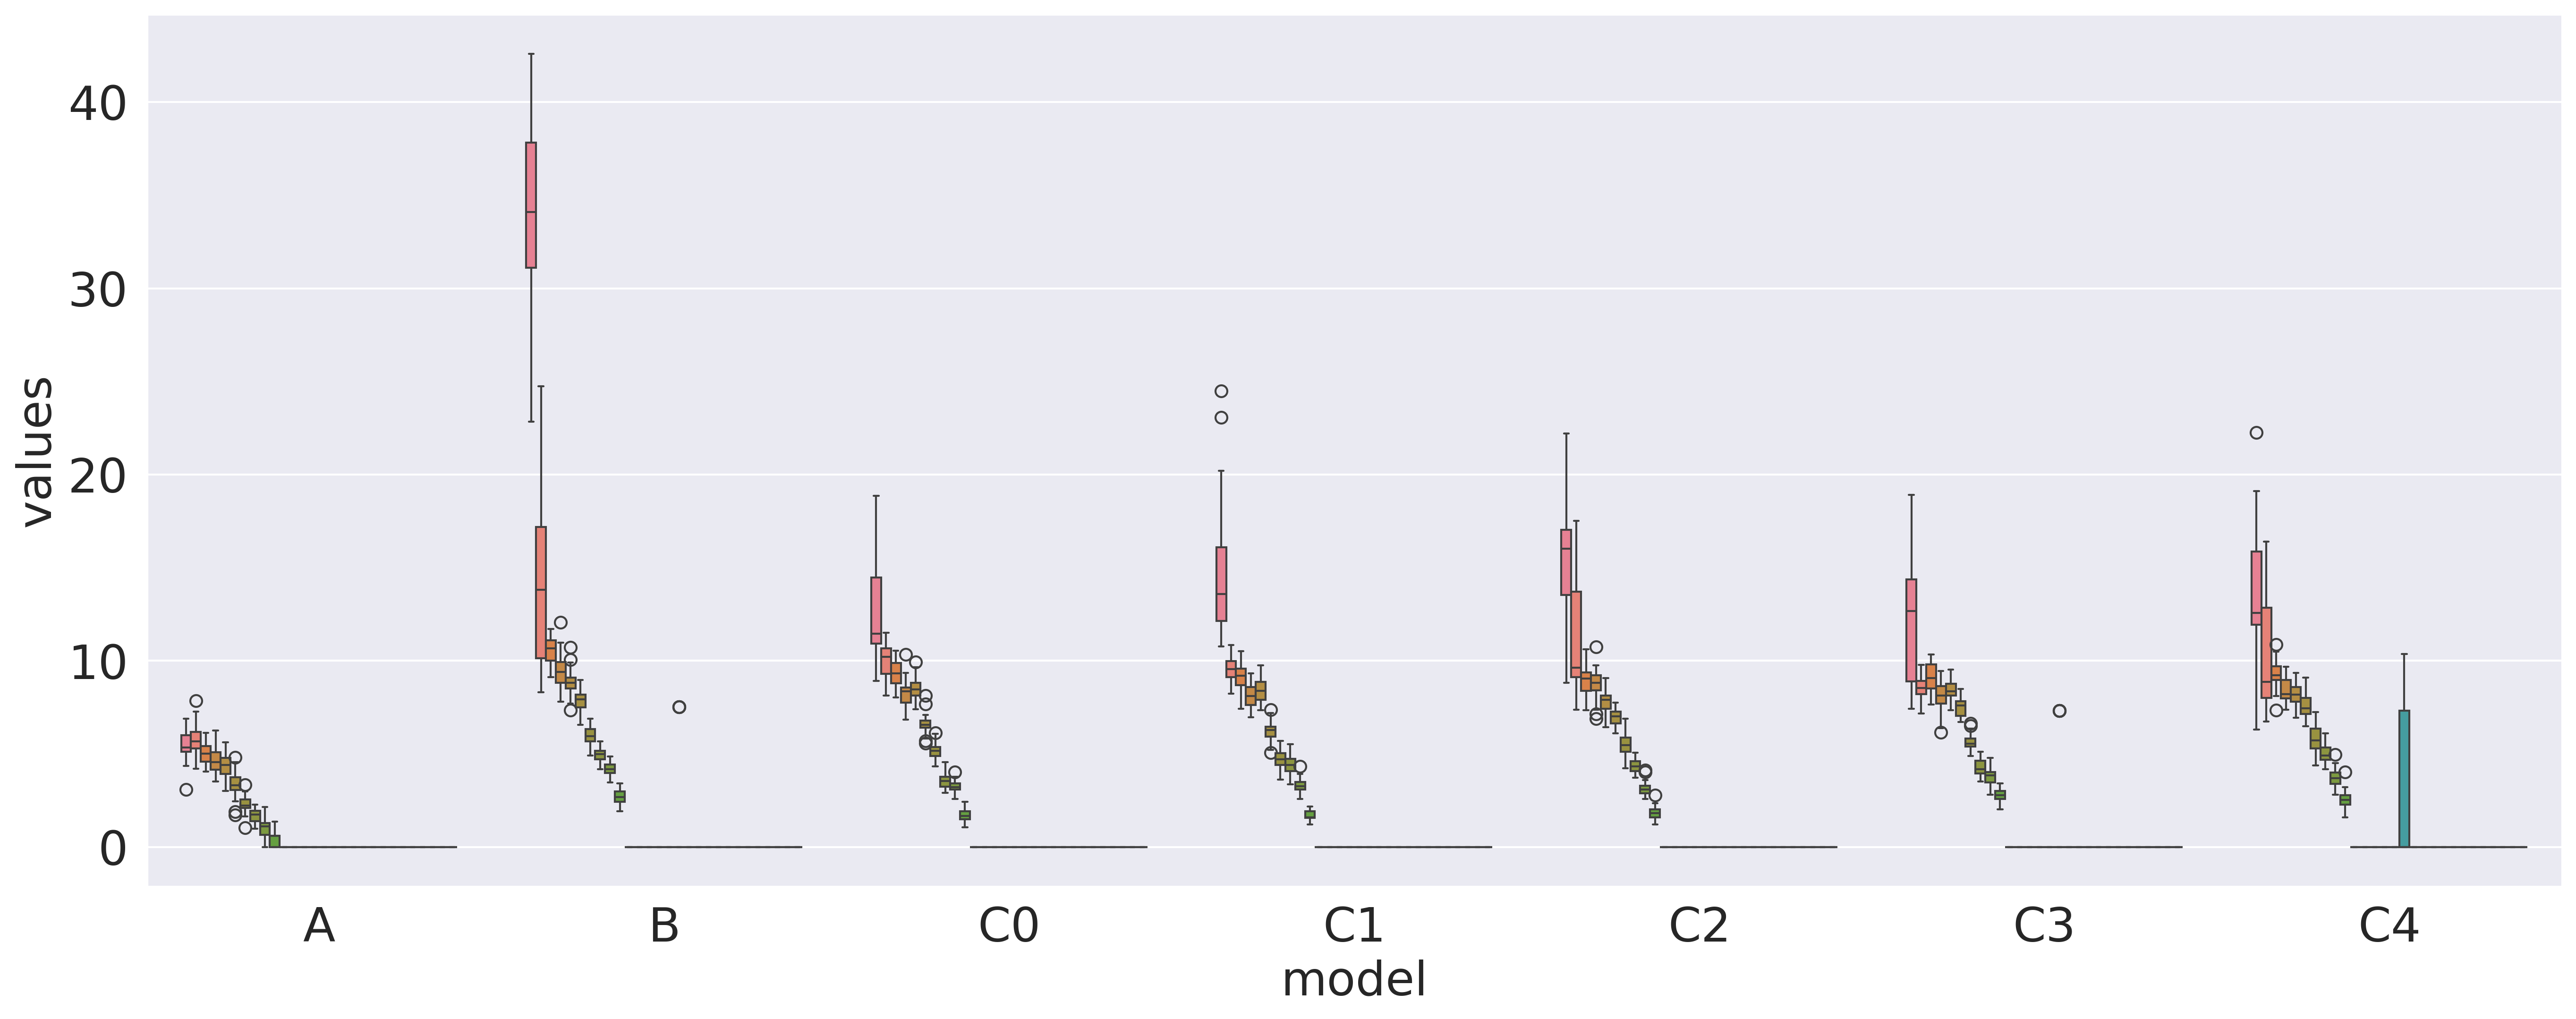

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '9.50e-01 <= y_pcf <= 9.70e-01 (5649)',
    'C1': '9.70e-01 <= y_pcf <= 9.90e-01 (5685)',
    'C2': '9.90e-01 <= y_pcf <= 1.01e+00 (5652)',
    'C3': '1.01e+00 <= y_pcf <= 1.03e+00 (5664)',
    'C4': '1.03e+00 <= y_pcf <= 1.05e+00 (5652)'
}

In [17]:
test_feature("y_pcf")

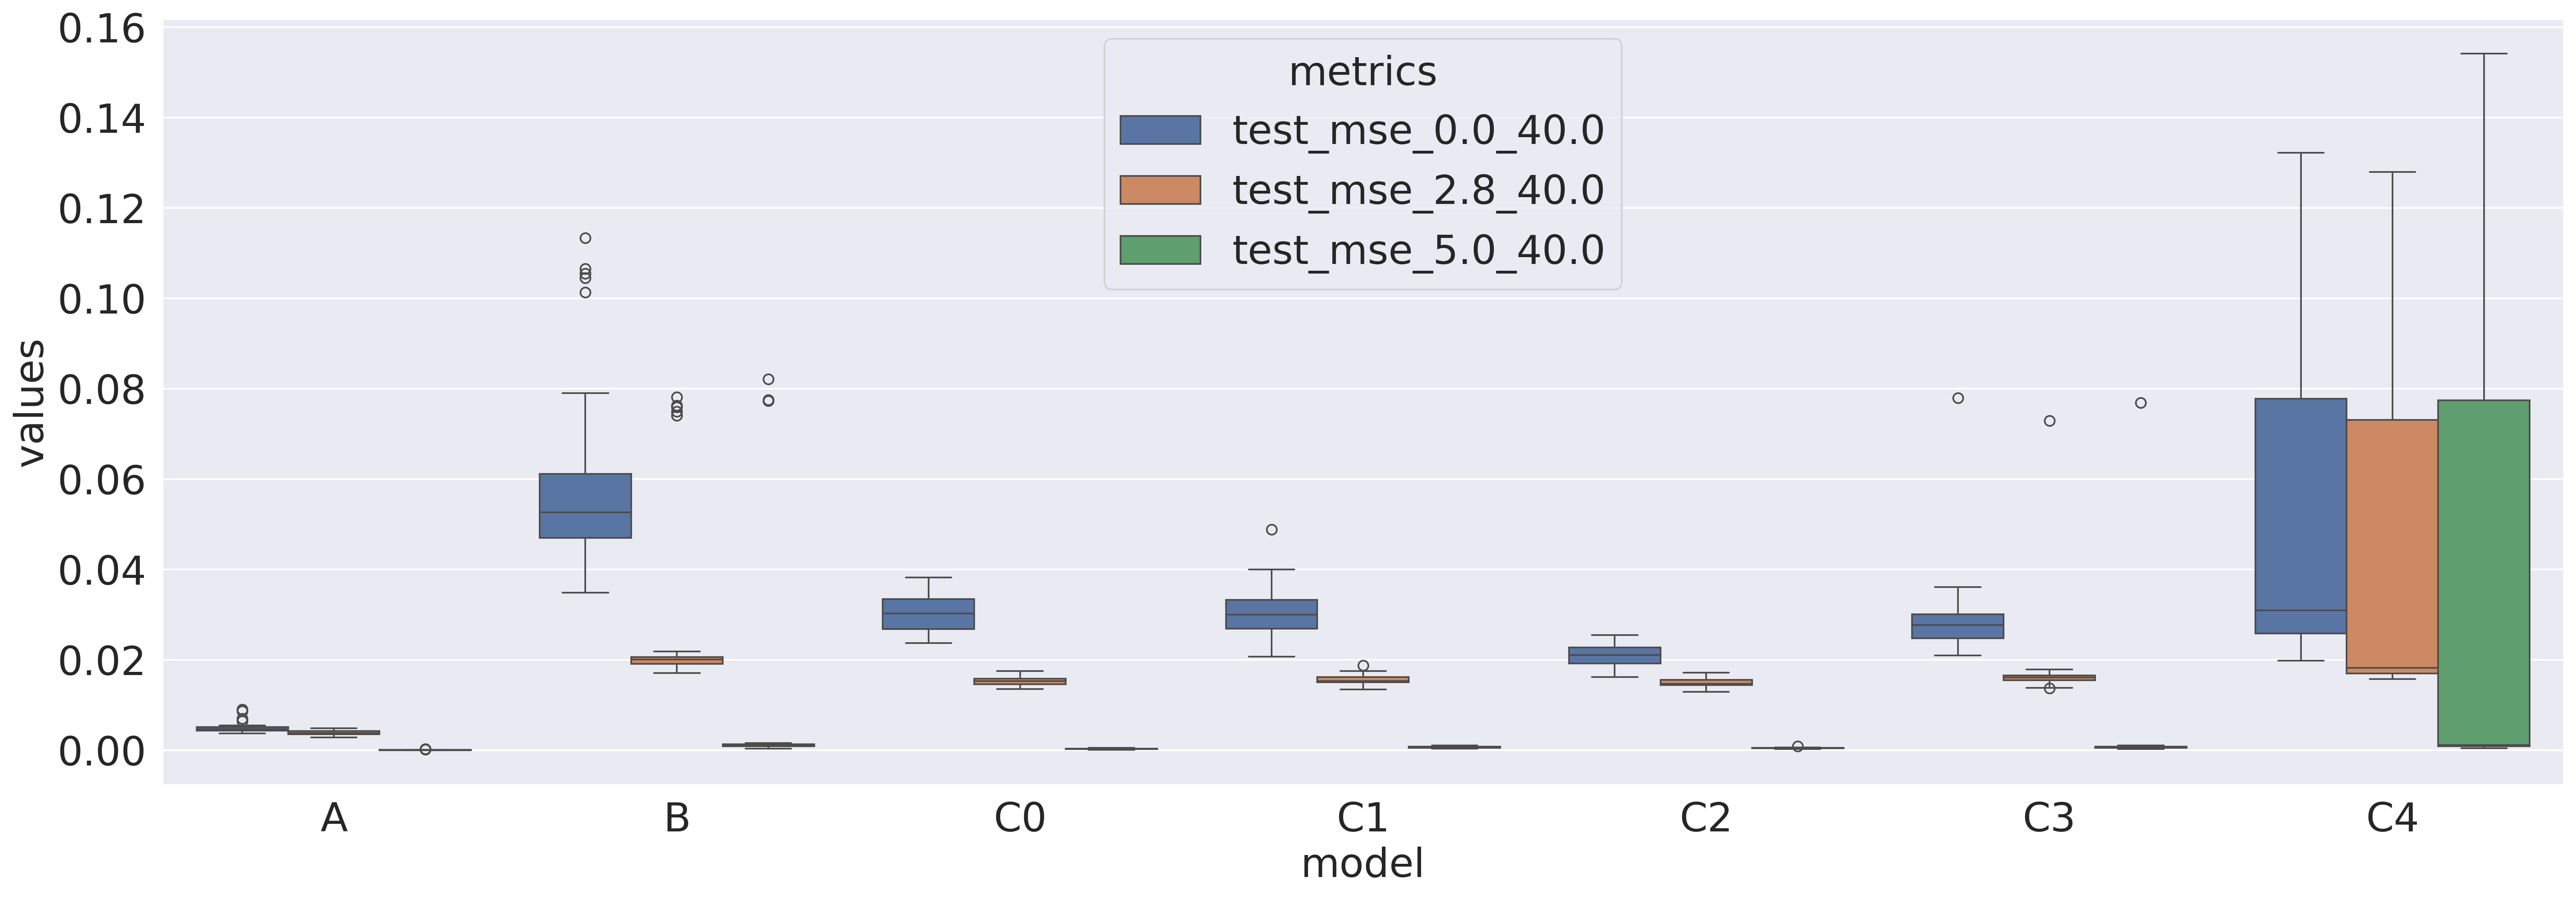

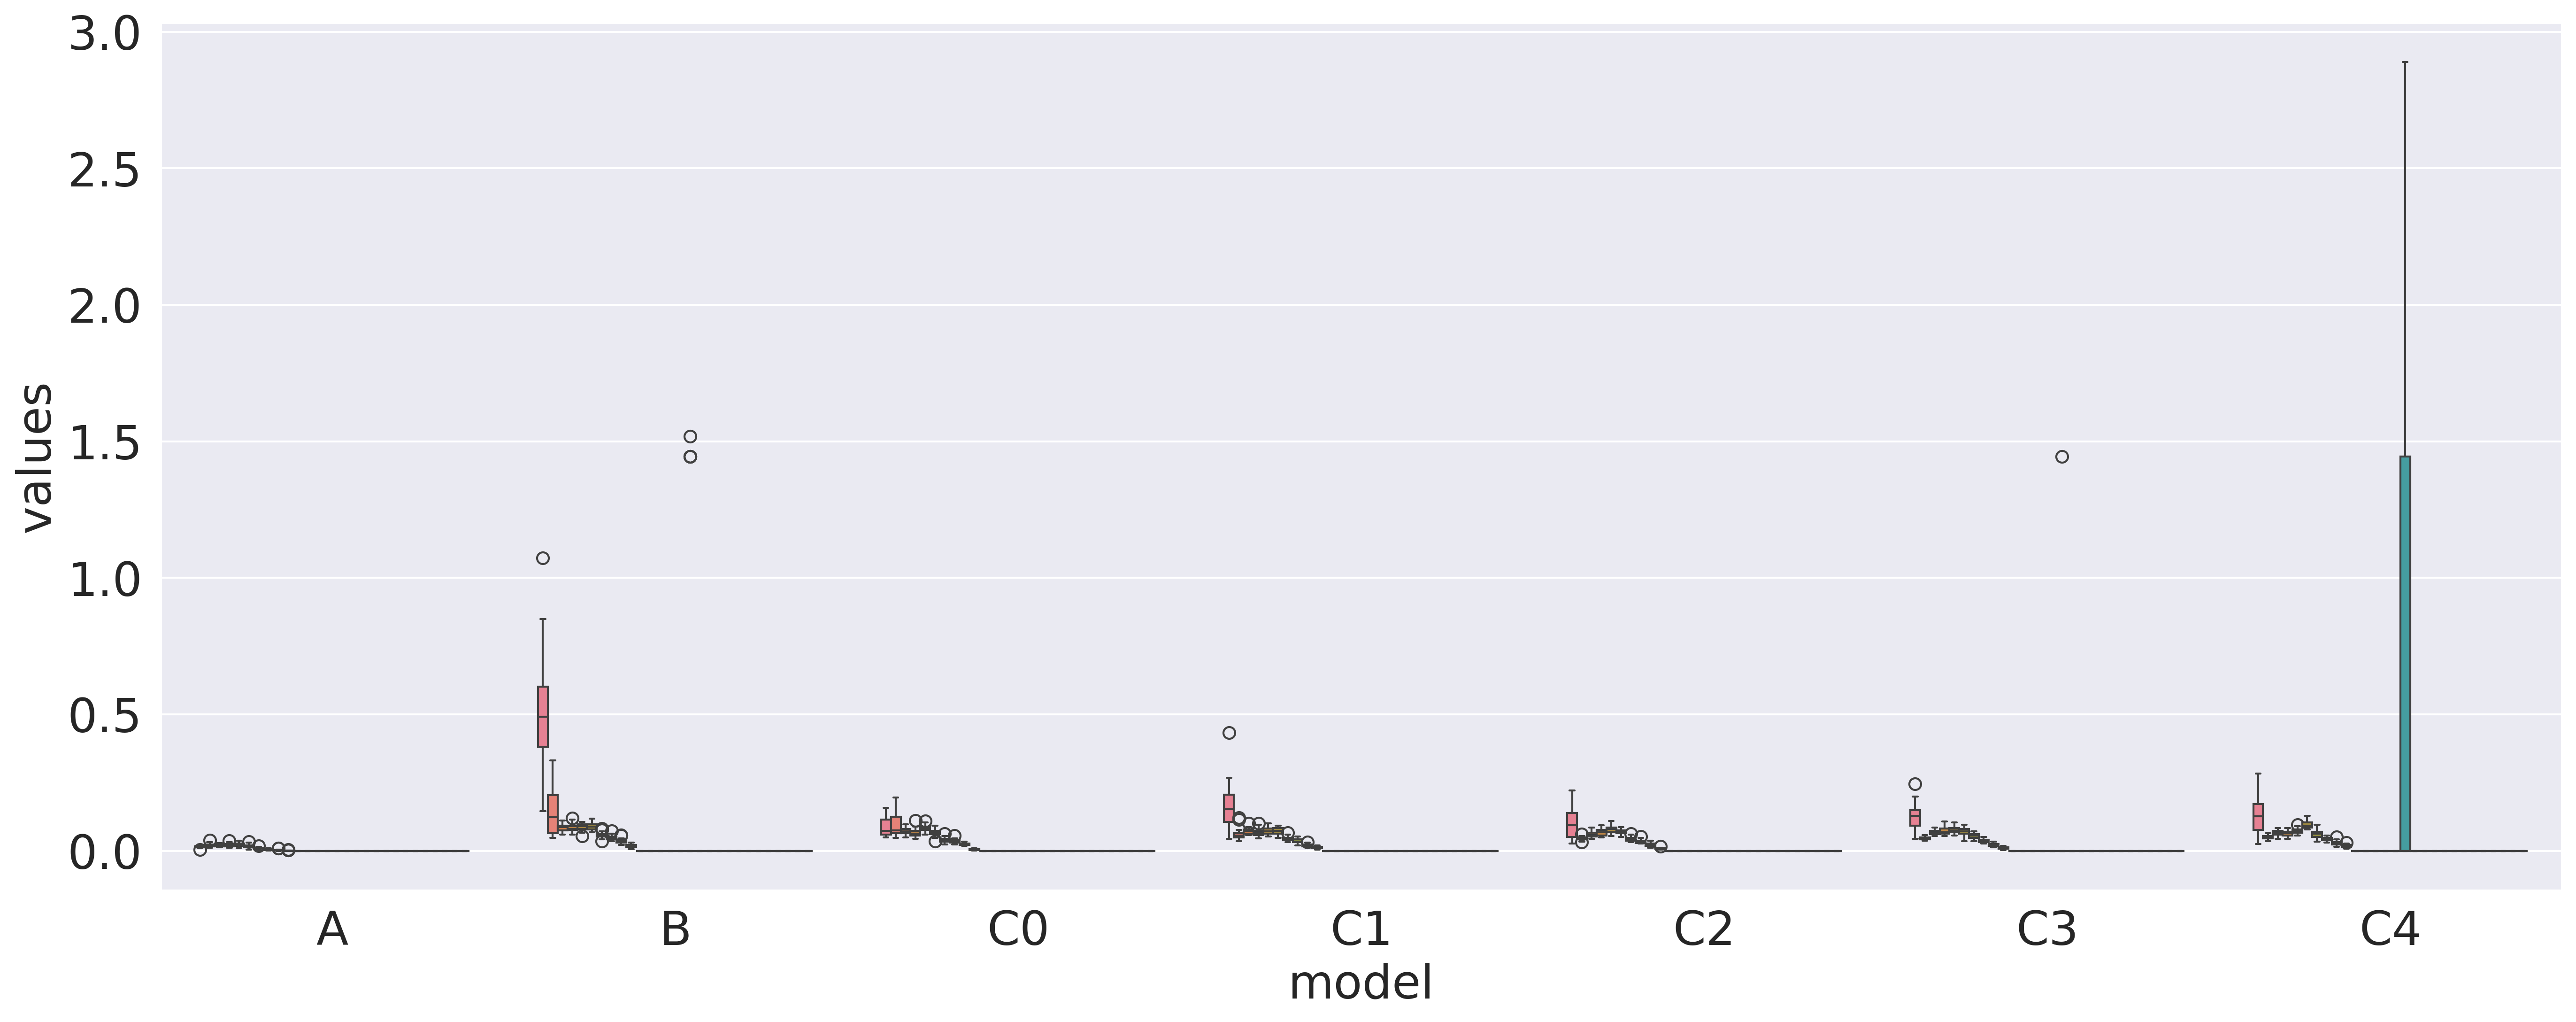

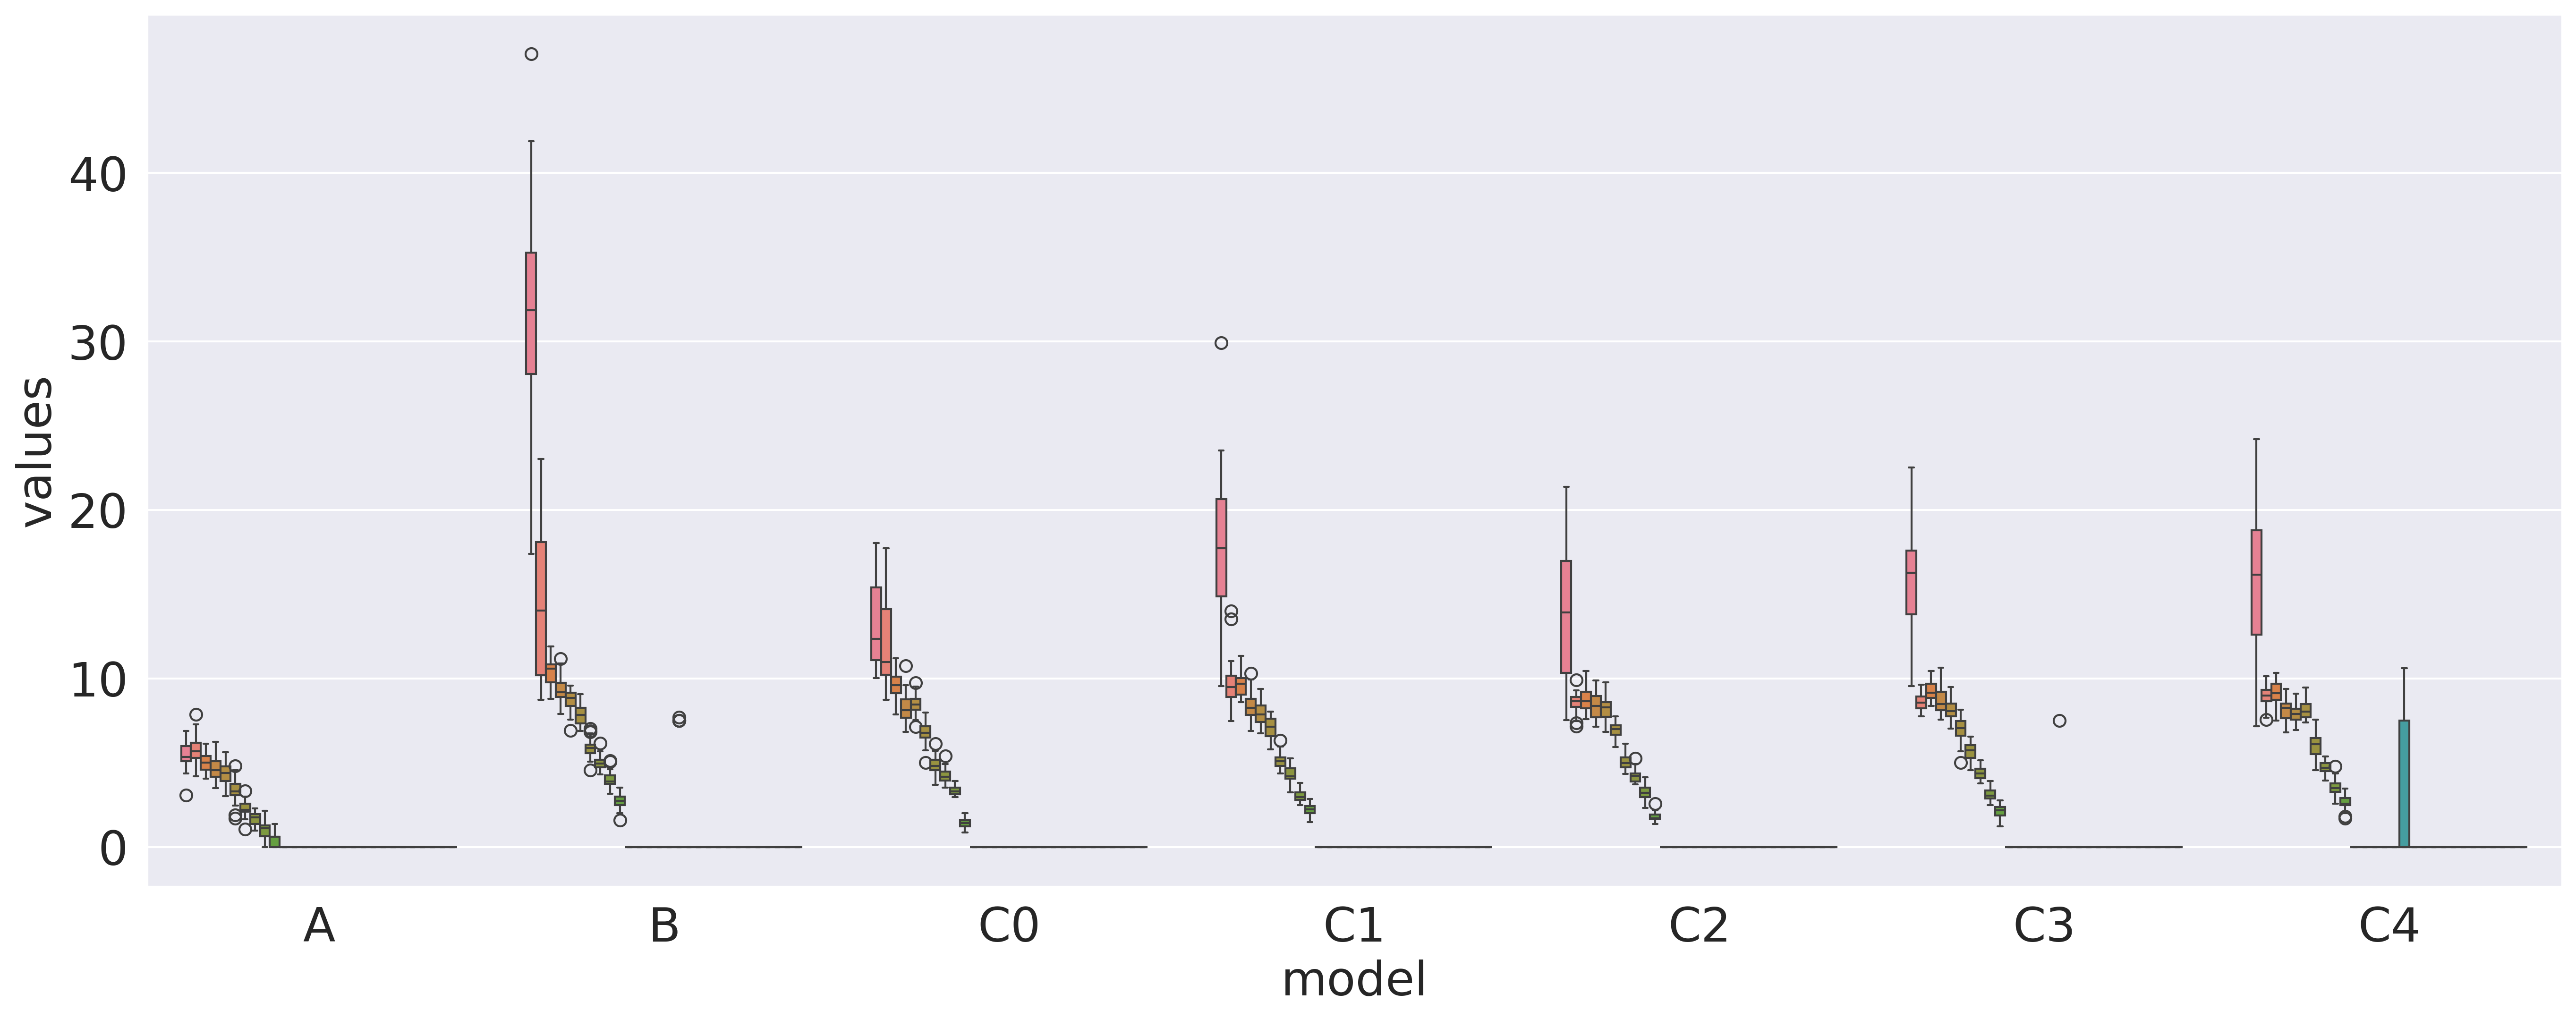

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '9.50e-01 <= y_ec_pwas <= 9.70e-01 (5647)',
    'C1': '9.70e-01 <= y_ec_pwas <= 9.90e-01 (5648)',
    'C2': '9.90e-01 <= y_ec_pwas <= 1.01e+00 (5666)',
    'C3': '1.01e+00 <= y_ec_pwas <= 1.03e+00 (5653)',
    'C4': '1.03e+00 <= y_ec_pwas <= 1.05e+00 (5688)'
}

In [18]:
test_feature("y_ec_pwas")

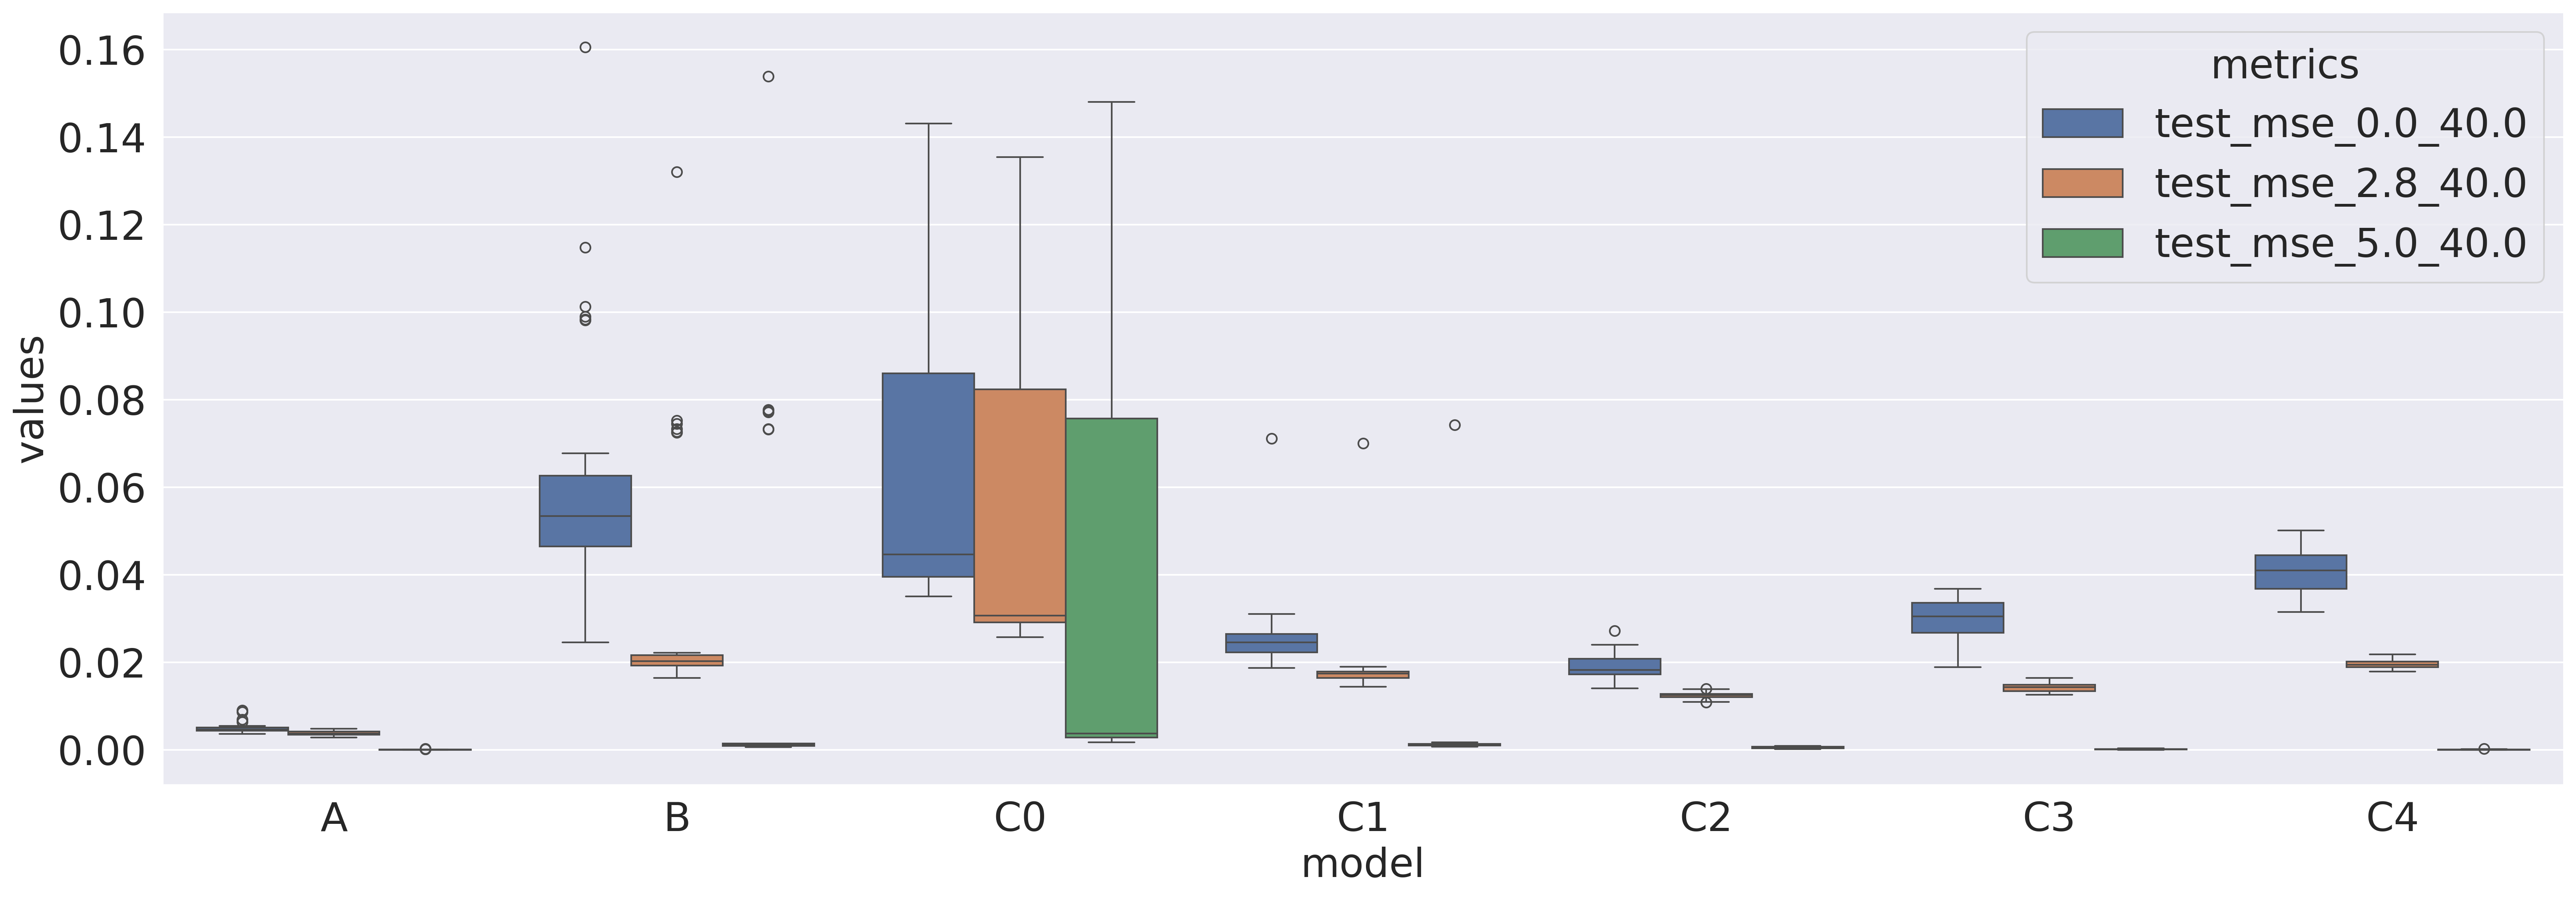

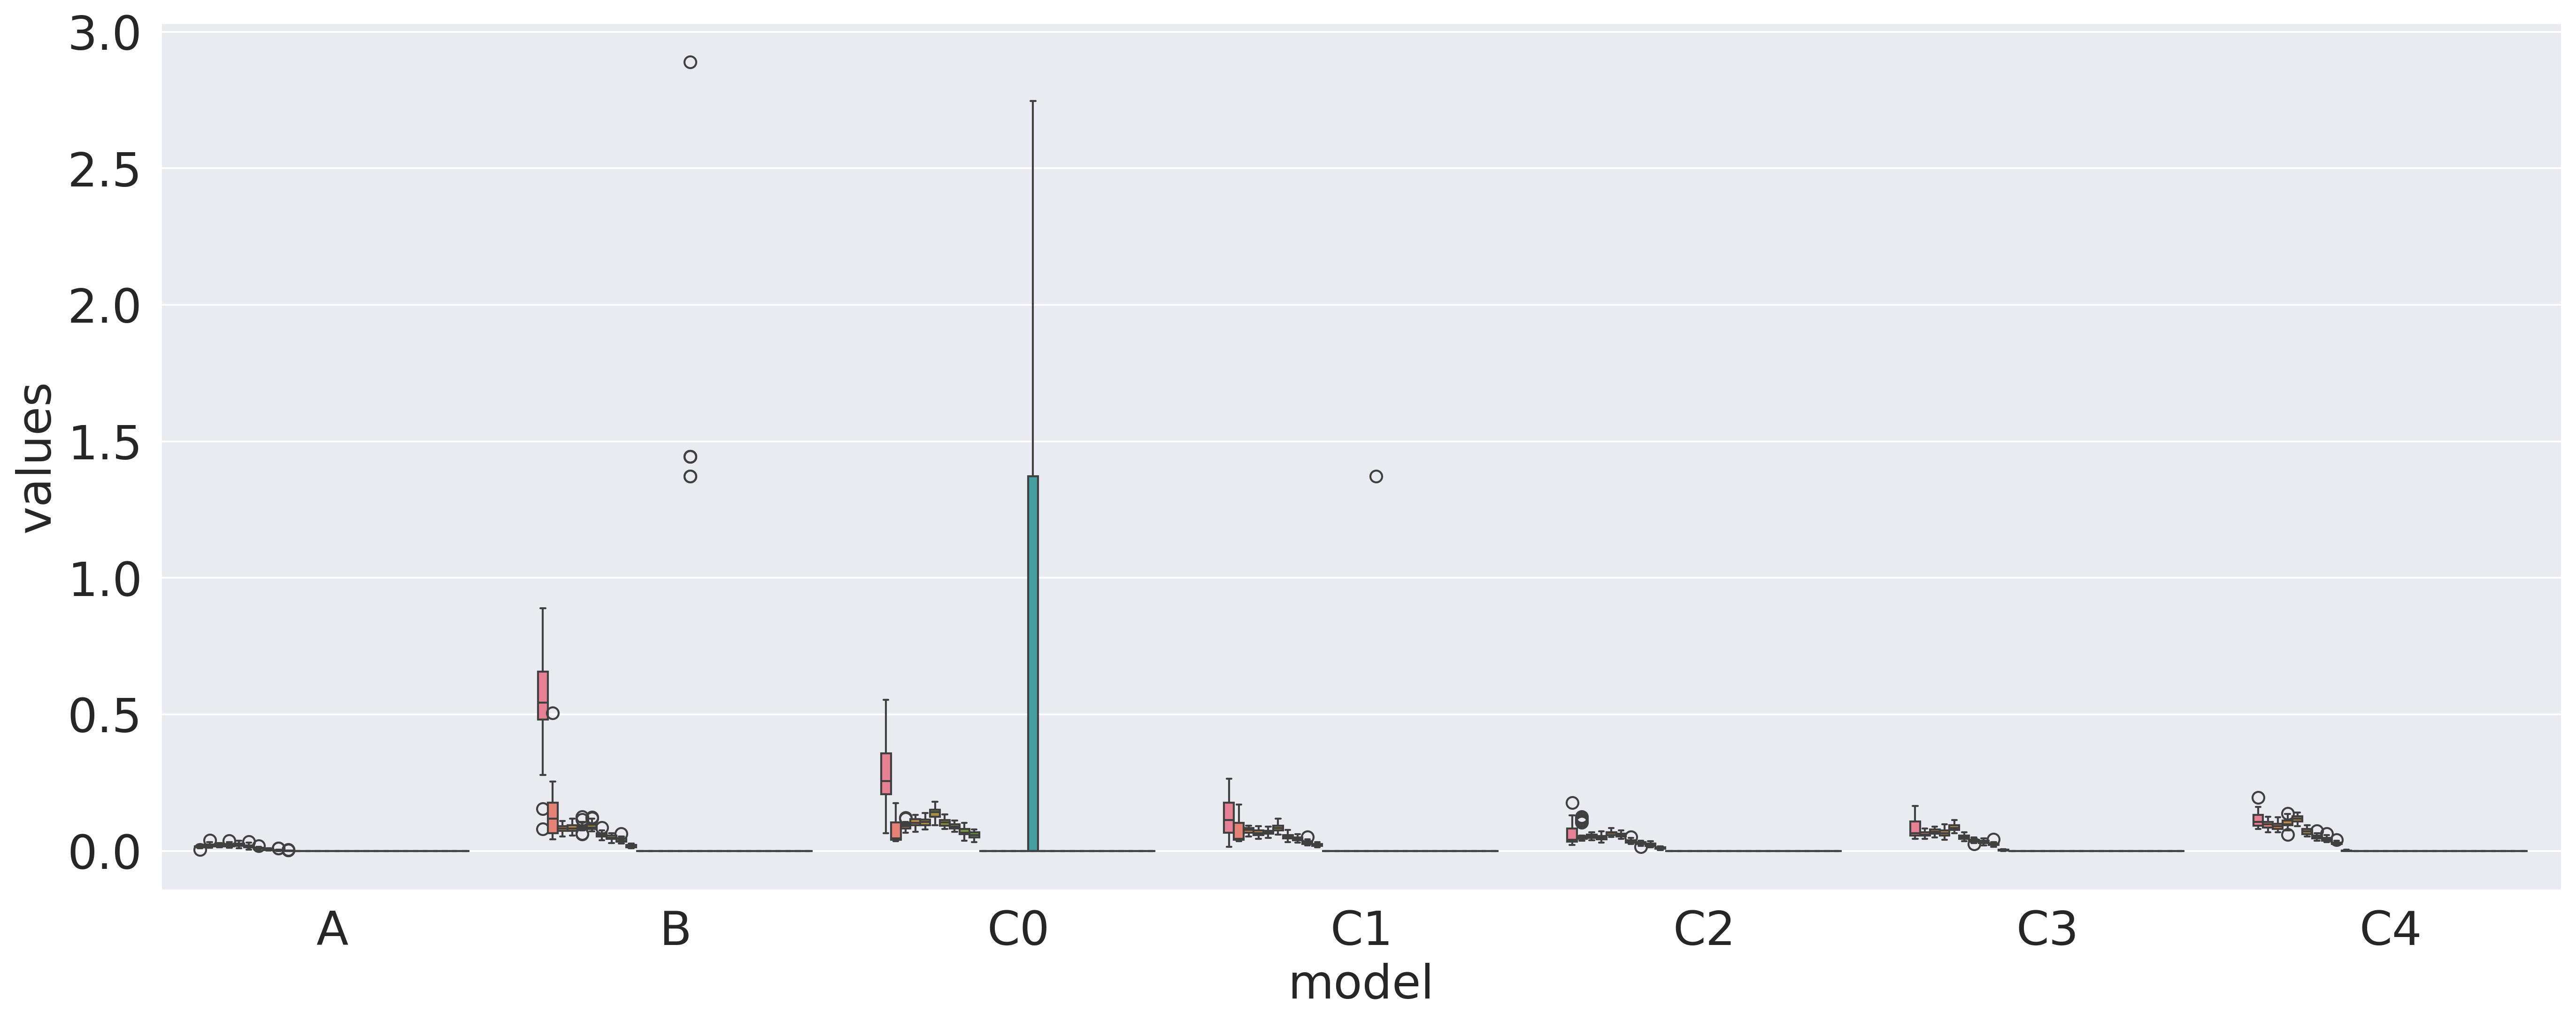

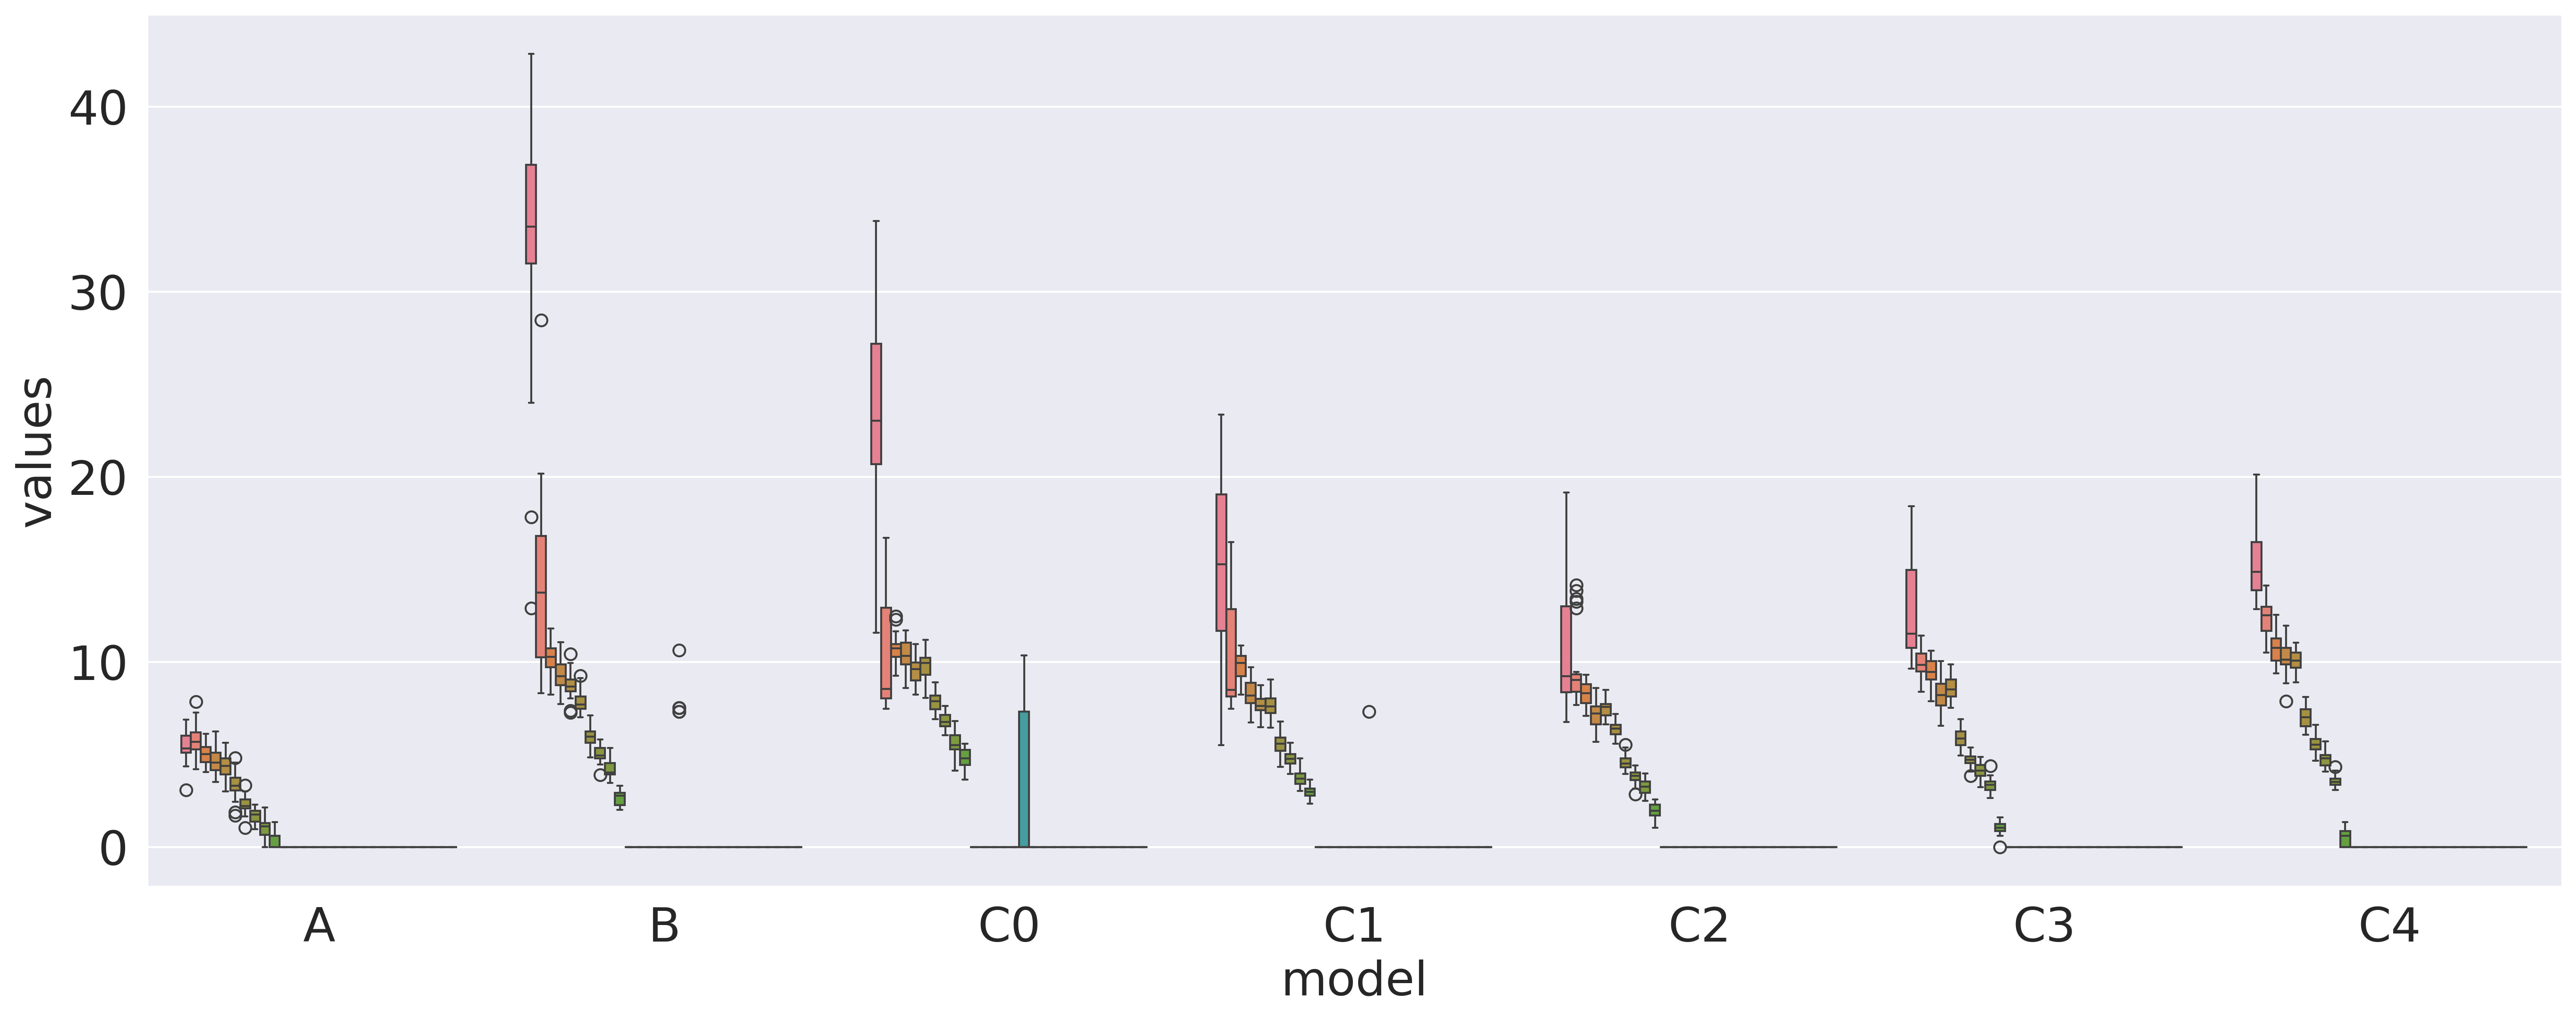

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '1.60e-02 <= y_loss_f <= 1.76e-02 (5852)',
    'C1': '1.76e-02 <= y_loss_f <= 1.92e-02 (5354)',
    'C2': '1.92e-02 <= y_loss_f <= 2.08e-02 (6061)',
    'C3': '2.08e-02 <= y_loss_f <= 2.24e-02 (5566)',
    'C4': '2.24e-02 <= y_loss_f <= 2.40e-02 (5469)'
}

In [19]:
test_feature("y_loss_f")